<a href="https://colab.research.google.com/github/shaharbsh/ML-final-project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Self-training with Noisy Student improves ImageNet classification 

Shahar Ben Shaya - 208243220

Yuval Ben Shaya - 208243238

## Install and import dependencies

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
# tf.enable_eager_execution()

# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as sk
from sklearn.model_selection import KFold, RandomizedSearchCV
import time
import random


print(tf.__version__)


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
# tf.enable_eager_execution()

2.5.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create noisy student algorithm  

## Build the model
All models have the same base structure, we create them using the following function:

the model architecture is taken from the tutorial notebook of Fashion MNIST dataset

In [3]:
# input - the image dataset, num of classes to predict 
# output - a CNN model with imput shape of the images in the dataset 
#           with Adam optimizer and CE loss

def create_model(input,num_of_classes):
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                            input_shape=(input.shape[1],input.shape[2],input.shape[3])),
      tf.keras.layers.MaxPooling2D((2, 2), strides=2),
      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D((2, 2), strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(num_of_classes,  activation=tf.nn.softmax)
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

## train baseline and student

### baseline

we train the baseline algorithm using the model depicted above.

the data for the baseline model is only 5-10% of the data in the datset in order to recreate the conditions in the paper. 

In [4]:
def baseline_alg(x_train, y_train, teacher_factor=0.1, num_of_classes=10, batch_size=32, epochs=10):
  ## train baseline (first teacher) model ##
  baseline = create_model(x_train, num_of_classes)  # create the model
  # create baseline train size:
  TEACHER_SIZE = int(teacher_factor*x_train.shape[0])
  x_train_teacher = x_train[:TEACHER_SIZE]
  y_train_teacher = y_train[:TEACHER_SIZE]
  # train
  baseline.fit(x=x_train_teacher,y=y_train_teacher, epochs=epochs, batch_size=batch_size)
  return baseline

### noisy student

here we train the noisy student using the algorithm depicted in the paper. 

since all the data is labeled, we use only a part of it as labeld data and the rest as unlabeld data, this is manifested in the teacher_factor and unl_factor.

In [5]:
def noisy_student_alg(x_train, y_train, baseline, teacher_factor=0.1, unl_factor=0.2,
                      threshold=0.6, num_of_students=3, num_of_classes=10, batch_size=32, epochs=10):
  # create baseline train size:
  TEACHER_SIZE = int(teacher_factor*x_train.shape[0])
  x_train_teacher = x_train[:TEACHER_SIZE]
  y_train_teacher = y_train[:TEACHER_SIZE]
  ## train noisy students ##
  # initialze teacher and student parameters:
  UNL_ADD = int(unl_factor*x_train.shape[0])
  teacher_model = baseline
  image_idx = np.zeros(x_train.shape[0], dtype=bool)
  image_idx[range(TEACHER_SIZE)] = True
  # iterative student training:
  for i in range(num_of_students):
    ## creating new data for student ##
    # initilaize labels idx for student training
    label_idx = np.zeros(UNL_ADD, dtype=bool)
    # set unlabled data for psudu labeling: 
    teacher_size = TEACHER_SIZE + i*UNL_ADD
    student_size = TEACHER_SIZE + (i+1)*UNL_ADD
    if student_size > x_train.shape[0]:
      print('Early finish {} iteration stop'.format(i))
      return student_model
    # creating the unlabled data to predict
    unlabeled_data = x_train[teacher_size:student_size]
    # creating psudu labels
    psudu_labels = teacher_model.predict_classes(unlabeled_data)
    psudu_labels_prob = teacher_model.predict(unlabeled_data)
    for j, prob in enumerate(psudu_labels_prob):
      if prob.max() > threshold:
        image_idx[j+teacher_size] = True
        label_idx[j] = True

    # concating labels to new labels
    student_label = np.concatenate((y_train_teacher,psudu_labels[label_idx]))
    # setting the images for train
    student_images = x_train[image_idx]

    ## student model ##
    student_model = create_model(student_images, num_of_classes)
    student_model.fit(x=student_images,y=student_label, epochs=epochs, batch_size=batch_size)

    ## update teacher ##
    teacher_model = student_model
    y_train_teacher = student_label
  return student_model

## Improvment to the algotithm

### improvment algorithm - using ensemble of teachers

here we use an ensemble of teacher to train an ensemble of students in order to impove the predictions in each part of the algorithm

In [6]:
def improve_alg(x_train, y_train, baseline, ensemble_size=3, num_of_classes=10, teacher_factor=0.1, unl_factor=0.2, threshold=0.6, 
                      num_of_students=3, batch_size=32, epochs=10):
  ## train baseline (first teacher) model ##
  teachers = []
  teachers.append(baseline)
  # create baseline train size:
  TEACHER_SIZE = int(teacher_factor*x_train.shape[0])
  x_train_teacher = x_train[:TEACHER_SIZE]
  y_train_teacher = y_train[:TEACHER_SIZE]
  # train
  for i in range(ensemble_size-1):
    teachers.append(create_model(x_train, num_of_classes))  # create the model
    teachers[i+1].fit(x=x_train_teacher,y=y_train_teacher, epochs=epochs, batch_size=batch_size)

  ## train noisy students ##
  # initialze teacher and student parameters:
  UNL_ADD = int(unl_factor*x_train.shape[0])
  # teacher_model = baseline
  image_idx = np.zeros(x_train.shape[0], dtype=bool)
  image_idx[range(TEACHER_SIZE)] = True
  # iterative student training:
  for i in range(num_of_students):
    ## creating new data for student ##
    # initilaize labels idx for student training
    label_idx = np.zeros(UNL_ADD, dtype=bool)
    # set unlabled data for psudu labeling: 
    teacher_size = TEACHER_SIZE + i*UNL_ADD
    student_size = TEACHER_SIZE + (i+1)*UNL_ADD
    if student_size > x_train.shape[0]:
      print('Early finish {} iteration stop'.format(i))
      return student_model
    # creating the unlabled data to predict
    unlabeled_data = x_train[teacher_size:student_size]

    # creating psudu labels using ensemble prediction
    psudo_labels_prob = np.zeros((unlabeled_data.shape[0],num_of_classes))
    for teacher_model in teachers:
      prob_matrix = teacher_model.predict(unlabeled_data)
      psudo_labels_prob += prob_matrix
    psudo_labels_prob /= ensemble_size 
    psudo_labels = np.argmax(psudo_labels_prob, axis=1)
    for j, prob in enumerate(psudo_labels_prob):
      if prob.max() > threshold:
        image_idx[j+teacher_size] = True
        label_idx[j] = True

    # concating labels to new labels
    student_label = np.concatenate((y_train_teacher,psudo_labels[label_idx]))
    # setting the images for train
    student_images = x_train[image_idx]

    ## student model ##
    students = []
    for j in range(ensemble_size):
      students.append(create_model(student_images, num_of_classes))
      students[j].fit(x=student_images,y=student_label, epochs=epochs, batch_size=batch_size)

    ## update teacher ##
    teachers = students
    y_train_teacher = student_label
  return students

### predict function

for the ensemble method we needed to create our own prediction funcitons as follows:

predict function for the improved algorithm, the function return the classes of the images

In [7]:
def predict(x_test, students, num_of_classes=10, ensemble_size=3):
  labels_prob = np.zeros((x_test.shape[0],num_of_classes))
  for student_model in students:
    prob_matrix = student_model.predict(x_test)
    labels_prob += prob_matrix
  labels_prob /= ensemble_size 
  labels = np.argmax(labels_prob, axis=1)
  return labels 

predict prob function that return the probability to be in each class for each input image

In [8]:
def predict_prob(x_test, students, num_of_classes=10, ensemble_size=3):
  labels_prob = np.zeros((x_test.shape[0],num_of_classes))
  for student_model in students:
    prob_matrix = student_model.predict(x_test)
    labels_prob += prob_matrix
  labels_prob /= ensemble_size 
  # labels = np.argmax(labels_prob, axis=1)
  return labels_prob

# K - fold

in order to evaluate the algorithms we created the following functions:

In [9]:
# convert vector of int labels to one hot matrix - for metrics
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [10]:
# function for calculate FPR metrics
def multi_class_FPR(y_true, y_prediction):
  cnf_matrix = sk.confusion_matrix(y_true, y_prediction)
  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  TN = TN.astype(float)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  return FPR.mean()

calculate all metrics for each dataset

In [11]:
def get_metrics(df, columns, x_test_array, prob, labels, y_test_array, dsName, algoName, hyperParams,
                fold, training_time, inference_time, num_of_classes=10):
  # metrics to df
  accuracy = sk.accuracy_score(labels, y_test_array)
  TPR = sk.recall_score(y_test_array, labels, average='macro')
  percision = sk.precision_score(y_test_array, labels, average='macro')
  # prob = model.predict(x_test_array)
  onehot_y_test = one_hot(y_test_array,num_of_classes)
  ROC = sk.roc_auc_score(onehot_y_test, prob)
  pr = sk.average_precision_score(onehot_y_test, prob)
  FPR = multi_class_FPR(y_test_array, labels)
  row = pd.DataFrame([[dsName,algoName, fold, hyperParams, accuracy, TPR, FPR, percision,
                       ROC, pr, training_time,inference_time]], columns=columns)
  df = df.append(row, ignore_index=True) 
  return df

here is our function for the 10-fold cross validation, the outer loop creates the train and test sets, and the inner 3-fold cross validation is for the hyper parameters optimization of each algorithm in the fold. 

In [1]:
def k_fold(x_train, y_train, dsName, epochs, num_of_classes=10, teacher_factor=0.1):
  # creating df to save all the metrics for each dataset and then export them to csv file
  df = pd.DataFrame()
  columns = 'Dataset Name','Algorithm Name','Cross Validation [1-10]','Hyper-Parameters Values','Accuracy','TPR','FPR','Precision','AUC','PR-Curve','Training Time','Inference Time'
  KF = KFold(n_splits=10)
  # 10-fold
  fold = 1
  for trainVal, test in KF.split(x_train):
    print('outer fold = {}'.format(fold))
    x_trainVal_array = x_train[trainVal]
    y_trainVal_array = y_train[trainVal]
    x_test_array = x_train[test]
    y_test_array = y_train[test]
    KF_search = KFold(n_splits=3)
    max_Score_noisy = 0
    max_Score_ensemble = 0
    start = time.time()
    baseline = baseline_alg(x_trainVal_array, y_trainVal_array, num_of_classes=num_of_classes, teacher_factor=teacher_factor, epochs=epochs)
    end = time.time()
    baseline_training_time = end - start
    # 3-fold
    for train, val in KF_search.split(x_trainVal_array):
      x_train_array = x_trainVal_array[train]
      y_train_array = y_trainVal_array[train]
      x_val_array = x_trainVal_array[val]
      y_val_array = y_trainVal_array[val]
      # hyperparameters optimization
      for unl_factor in [0.2, 0.1, 0.05]:
        print('unl_factor: {}'.format(unl_factor))
        for threshold in [0.4,0.5,0.6,0.7,0,8]:
          print('threshold: {}'.format(threshold))
          # for noisy student algorithm
          for num_of_students in [1,2,3]:
            print('num_of_students: {}'.format(num_of_students))
            start = time.time()
            student_model = noisy_student_alg(x_train_array, y_train_array, baseline,
                                              teacher_factor=teacher_factor,
                                              unl_factor=unl_factor,threshold=threshold,
                                              num_of_students=num_of_students,
                                              num_of_classes=num_of_classes, epochs=epochs)
            end = time.time()
            noisy_training_time = end - start
            start = time.time()
            labels = student_model.predict_classes(x_val_array)
            end = time.time()
            noisy_inference_time = end - start
            score_noisy = sk.accuracy_score(labels, y_val_array)
            # find the best model
            if max_Score_noisy < score_noisy: 
              max_Score_noisy = score_noisy
              unl_factor_best = unl_factor
              threshold_best = threshold
              num_of_students_best = num_of_students
              student_model_best = student_model
            print()
    # for noisy student improved algorithm
    for ensemble_size in [2,3]:
      print('ensemble_size: {}'.format(ensemble_size))
      start = time.time()
      students = improve_alg(x_train_array, y_train_array, baseline, ensemble_size=ensemble_size,
                              unl_factor=unl_factor_best, num_of_students=num_of_students_best,
                            threshold=threshold_best, num_of_classes=num_of_classes, epochs=epochs)
      end = time.time()
      ensemble_training_time = end - start
      start = time.time()
      labels = predict(x_val_array, students, num_of_classes=num_of_classes, ensemble_size=ensemble_size)
      end = time.time()
      ensemble_inference_time = end - start
      score_ensemble = sk.accuracy_score(labels, y_val_array)
      if max_Score_ensemble < score_ensemble: 
        max_Score_ensemble = score_ensemble
        ensemble_size_best = ensemble_size
        students_best = students
    # baseline evaluation
    start = time.time()
    labels_baseline = baseline.predict_classes(x_test_array)
    end = time.time()
    baseline_inference_time = end - start
    # save to df
    algoName = 'Baseline'
    hyperParams = 'None'
    prob_baseline = baseline.predict(x_test_array)
    df = get_metrics(df, columns, x_test_array, prob_baseline, labels_baseline, y_test_array, dsName, algoName, hyperParams,
                  fold, baseline_training_time, baseline_inference_time, num_of_classes=num_of_classes) 

    # noisy student evaluation
    labels_noisy = student_model_best.predict_classes(x_test_array)
    # save to df
    algoName = 'Noisy Student'
    hyperParams = 'unl_factor: {}'.format(unl_factor_best) + ', threshold: {}'.format(threshold_best) + ', num_of_students: {}'.format(num_of_students_best)
    prob_noisy = student_model_best.predict(x_test_array)
    df = get_metrics(df, columns, x_test_array, prob_noisy, labels_noisy, y_test_array, dsName, algoName, hyperParams,
                  fold, noisy_training_time, noisy_inference_time, num_of_classes=num_of_classes)

    # improvement evaluation
    labels_ensemble = predict(x_test_array, students_best, num_of_classes=num_of_classes, ensemble_size=ensemble_size_best)
    # save to df
    algoName = 'Improved Noisy Student'
    hyperParams = 'unl_factor: {}'.format(unl_factor_best) + ', threshold: {}'.format(threshold_best) + ', num_of_students: {}'.format(num_of_students_best) + ', ensemble_size: {}'.format(ensemble_size_best)
    prob_ensemble = predict_prob(x_test_array, students_best, num_of_classes=num_of_classes, ensemble_size=ensemble_size_best)
    df = get_metrics(df, columns, x_test_array, prob_ensemble, labels_ensemble, y_test_array, dsName, algoName, hyperParams,
                  fold, ensemble_training_time, ensemble_inference_time, num_of_classes=num_of_classes)

    fold += 1
    

  # export the df to csv file for each dataset  
  df.to_csv('/content/drive/MyDrive/University/סמסטר ו/למידה חישובית יישומית/פרוייקט/{}.csv'.format(dsName))




the function above automaticaly saves the results of the given dataset as a csv file, after we have all the csv files for all the datasets, we manualy merged them to one for the Friedman test

# Fashion MNIST

## Import the Fashion MNIST dataset

> Indented block





The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [13]:
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## reshape dataset

In [14]:
x_train_fashion = np.stack(x_train_fashion, axis=0)
x_train_fashion = np.expand_dims(x_train_fashion,axis=3)
x_train_fashion.shape

(60000, 28, 28, 1)

In [15]:
y_train_fashion = np.stack(y_train_fashion, axis=0)
y_train_fashion.shape

(60000,)

9


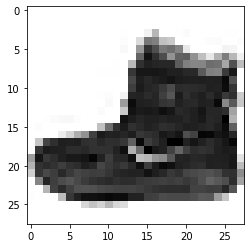

In [16]:
print(y_train_fashion[0])
plt.figure()
plt.imshow(np.squeeze(x_train_fashion[0]), cmap=plt.cm.binary)

## Preprocess the data



## normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [17]:
x_train_fashion = x_train_fashion.astype('float32')
x_train_fashion /= 255

### 10-fold cross validation

In [ ]:
dsName = 'Fashion MNIST'
epochs = 5
k_fold(x_train_fashion, y_train_fashion, dsName=dsName, epochs=epochs)

# MNIST

## Import the MNIST dataset

In [18]:
(x_train_MNIST, y_train_MNIST), (x_test_MNIST, y_test_MNIST) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


## reshape dataset

In [19]:
x_train_MNIST = np.stack(x_train_MNIST, axis=0)
x_train_MNIST = np.expand_dims(x_train_MNIST,axis=3)
x_train_MNIST.shape

(60000, 28, 28, 1)

In [20]:
y_train_MNIST = np.stack(y_train_MNIST, axis=0)
y_train_MNIST.shape

(60000,)

5


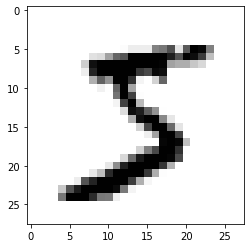

In [21]:
print(y_train_MNIST[0])
plt.figure()
plt.imshow(np.squeeze(x_train_MNIST[0]), cmap=plt.cm.binary)

## MNIST classes: 0-4

### reshape dataset

In [22]:
indexes_train = np.zeros(x_train_MNIST.shape[0], dtype=bool)
indexes_train[y_train_MNIST<=4] = True
x_train_MNIST0_4 = x_train_MNIST[indexes_train==True]
y_train_MNIST0_4 = y_train_MNIST[indexes_train==True]

0


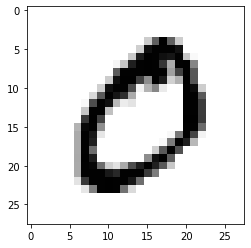

In [23]:
print(y_train_MNIST0_4[0])
plt.figure()
plt.imshow(np.squeeze(x_train_MNIST0_4[0]), cmap=plt.cm.binary)

In [24]:
x_train_MNIST0_4.shape

(30596, 28, 28, 1)

In [25]:
y_train_MNIST0_4.shape

(30596,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [26]:
x_train_MNIST0_4 = x_train_MNIST0_4.astype('float32')
x_train_MNIST0_4 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'MNIST 0-4'
epochs = 5
k_fold(x_train_MNIST0_4, y_train_MNIST0_4, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3124 - accuracy: 0.8950
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0844 - accuracy: 0.9728
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0415 - accuracy: 0.9866
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0282 - accuracy: 0.9916
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9946
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 4ms/step - loss: 0.2630 - accuracy: 0.9181
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0594 - accuracy: 0.9828
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0330 - accuracy: 0.9899
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9899
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.9943
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1757 - accuracy: 0.9471
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0430 - accuracy: 0.9869
Epoch 3/5
172/172 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9927
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9951
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0155 - accuracy: 0.9934

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3090 - accuracy: 0.9165
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9709
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9855
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9927
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9956
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2533 - accuracy: 0.9235
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9825
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0343 - accuracy: 0.9902
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9923
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.9964
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1872 - accuracy: 0.9391
Epoch 2/5
172/172 [==============================] - 0s 3ms/step - loss: 0.0409 - accuracy: 0.9874
Epoch 3/5
172/172 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9934
Epoch 4/5
172/172 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9943
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0109 - accuracy: 0.9956

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3071 - accuracy: 0.9161
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0750 - accuracy: 0.9749
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9844
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.9935
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9946
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2585 - accuracy: 0.9217
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9781
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0368 - accuracy: 0.9896
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9871
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9937
Epoch 1/5
171/171 [==============================] - 1s 3ms/step - loss: 0.2070 - accuracy: 0.9367
Epoch 2/5
171/171 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9848
Epoch 3/5
171/171 [==============================] - 1s 3ms/step - loss: 0.0327 - accuracy: 0.9888
Epoch 4/5
171/171 [==============================] - 1s 3ms/step - loss: 0.0252 - accuracy: 0.9901
Epoch 5/5
171/171 [==============================] - 1s 3ms/step - loss: 0.0171 - accuracy: 0.9929

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
87/87 [==============================] - 1s 4ms/step - loss: 0.3291 - accuracy: 0.8990
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0859 - accuracy: 0.9746
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9869
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0325 - accuracy: 0.9895
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0199 - accuracy: 0.9946
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2499 - accuracy: 0.9280
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.9833
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0369 - accuracy: 0.9880
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9945
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 0.9981
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1991 - accuracy: 0.9363
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0371 - accuracy: 0.9889
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0278 - accuracy: 0.9903
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0190 - accuracy: 0.9940
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0074 - accuracy: 0.9982

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3078 - accuracy: 0.9088
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0843 - accuracy: 0.9731
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 0.9855
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 0.9913
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 0.9931
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2307 - accuracy: 0.9224
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0412 - accuracy: 0.9869
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9918
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9926
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9951
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1711 - accuracy: 0.9505
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0301 - accuracy: 0.9920
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0241 - accuracy: 0.9912
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 0.9956
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0089 - accuracy: 0.9973

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3276 - accuracy: 0.8928
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0977 - accuracy: 0.9702
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0457 - accuracy: 0.9873
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9913
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9924
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2296 - accuracy: 0.9289
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0464 - accuracy: 0.9874
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0330 - accuracy: 0.9885
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9934
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9967
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1704 - accuracy: 0.9492
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0345 - accuracy: 0.9902
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0189 - accuracy: 0.9936
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.9956
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0097 - accuracy: 0.9965

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3515 - accuracy: 0.8928
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0768 - accuracy: 0.9797
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0844 - accuracy: 0.9709
Epoch 4/5
87/87 [==============================] - 0s 4ms/step - loss: 0.0311 - accuracy: 0.9895
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9935
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2406 - accuracy: 0.9227
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0391 - accuracy: 0.9885
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9937
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.9942
Epoch 5/5
115/115 [==============================] - 0s 4ms/step - loss: 0.0111 - accuracy: 0.9973
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1566 - accuracy: 0.9509
Epoch 2/5
172/172 [==============================] - 1s 4ms/step - loss: 0.0309 - accuracy: 0.9905
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0185 - accuracy: 0.9940
Epoch 4/5
172/172 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9951
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0083 - accuracy: 0.9973

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
87/87 [==============================] - 1s 4ms/step - loss: 0.3368 - accuracy: 0.9056
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9778
Epoch 3/5
87/87 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9807
Epoch 4/5
87/87 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 0.9902
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9938
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2567 - accuracy: 0.9133
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0514 - accuracy: 0.9828
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 0.9893
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.9945
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.9964
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1788 - accuracy: 0.9407
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0376 - accuracy: 0.9876
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0254 - accuracy: 0.9912
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0146 - accuracy: 0.9945
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9971

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.2830 - accuracy: 0.9161
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.9640
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0398 - accuracy: 0.9873
Epoch 4/5
87/87 [==============================] - 0s 4ms/step - loss: 0.0259 - accuracy: 0.9924
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9949
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2350 - accuracy: 0.9278
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9811
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9929
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 0.9954
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.9978
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1768 - accuracy: 0.9374
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0350 - accuracy: 0.9894
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0167 - accuracy: 0.9951
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0117 - accuracy: 0.9962
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0062 - accuracy: 0.9978

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
87/87 [==============================] - 1s 3ms/step - loss: 0.3277 - accuracy: 0.8968
Epoch 2/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0754 - accuracy: 0.9757
Epoch 3/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9855
Epoch 4/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.9924
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9935
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 0.2280 - accuracy: 0.9273
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.9866
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9915
Epoch 4/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9910
Epoch 5/5
115/115 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.9962
Epoch 1/5
172/172 [==============================] - 1s 3ms/step - loss: 0.1742 - accuracy: 0.9415
Epoch 2/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0308 - accuracy: 0.9903
Epoch 3/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0200 - accuracy: 0.9931
Epoch 4/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0133 - accuracy: 0.9960
Epoch 5/5
172/172 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.9974

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## MNIST classes: 5-9

### reshape dataset

In [27]:
indexes_train = np.zeros(x_train_MNIST.shape[0], dtype=bool)
indexes_train[y_train_MNIST>=5] = True
x_train_MNIST5_9 = x_train_MNIST[indexes_train==True]
y_train_MNIST5_9 = y_train_MNIST[indexes_train==True]

In [28]:
x_train_MNIST5_9.shape

(29404, 28, 28, 1)

rescale labels to start from 0

In [29]:
y_train_MNIST5_9 = y_train_MNIST5_9 - 5

0


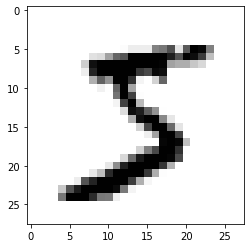

In [30]:
print(y_train_MNIST5_9[0])
plt.figure()
plt.imshow(np.squeeze(x_train_MNIST5_9[0]), cmap=plt.cm.binary)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [31]:
x_train_MNIST5_9 = x_train_MNIST5_9.astype('float32')
x_train_MNIST5_9 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'MNIST 5-9'
epochs = 5
k_fold(x_train_MNIST5_9, y_train_MNIST5_9, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
83/83 [==============================] - 32s 4ms/step - loss: 0.4407 - accuracy: 0.8549
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9664
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0674 - accuracy: 0.9792
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9834
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9906
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 4ms/step - loss: 0.3518 - accuracy: 0.8814
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0872 - accuracy: 0.9732
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0491 - accuracy: 0.9835
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 0.9897
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9929
Epoch 1/5
165/165 [==============================] - 1s 4ms/step - loss: 0.2706 - accuracy: 0.9098
Epoch 2/5
165/165 [==============================] - 0s 3ms/step - loss: 0.0599 - accuracy: 0.9814
Epoch 3/5
165/165 [==============================] - 0s 3ms/step - loss: 0.0422 - accuracy: 0.9871
Epoch 4/5
165/165 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9914
Epoch 5/5
165/165 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9916

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4155 - accuracy: 0.8575
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1187 - accuracy: 0.9588
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.9777
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 0.9819
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9924
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3380 - accuracy: 0.8800
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9743
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9831
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9874
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 0.9886
Epoch 1/5
164/164 [==============================] - 1s 3ms/step - loss: 0.2762 - accuracy: 0.9064
Epoch 2/5
164/164 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 0.9809
Epoch 3/5
164/164 [==============================] - 1s 3ms/step - loss: 0.0334 - accuracy: 0.9886
Epoch 4/5
164/164 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.9933
Epoch 5/5
164/164 [==============================] - 1s 3ms/step - loss: 0.0184 - accuracy: 0.9926

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.8458
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1122 - accuracy: 0.9664
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9777
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.9875
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9940
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.8812
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0787 - accuracy: 0.9737
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0488 - accuracy: 0.9834
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9874
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9891
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2654 - accuracy: 0.9077
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0586 - accuracy: 0.9796
Epoch 3/5
165/165 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 0.9882
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0204 - accuracy: 0.9931
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0231 - accuracy: 0.9911

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4446 - accuracy: 0.8587
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9645
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9792
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9898
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9928
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3645 - accuracy: 0.8830
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9721
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 0.9815
Epoch 4/5
110/110 [==============================] - 0s 4ms/step - loss: 0.0345 - accuracy: 0.9895
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9915
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2677 - accuracy: 0.9063
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0667 - accuracy: 0.9770
Epoch 3/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0424 - accuracy: 0.9858
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 0.9897
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0180 - accuracy: 0.9934

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4067 - accuracy: 0.8760
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1061 - accuracy: 0.9630
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0526 - accuracy: 0.9837
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0344 - accuracy: 0.9890
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9932
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3482 - accuracy: 0.8766
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0893 - accuracy: 0.9709
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0444 - accuracy: 0.9860
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.9886
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9929
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2817 - accuracy: 0.9036
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0655 - accuracy: 0.9770
Epoch 3/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0432 - accuracy: 0.9859
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0268 - accuracy: 0.9914
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9920

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4139 - accuracy: 0.8609
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1030 - accuracy: 0.9660
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0472 - accuracy: 0.9849
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9917
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9917
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 4ms/step - loss: 0.3529 - accuracy: 0.8774
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9730
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9889
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0306 - accuracy: 0.9920
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9946
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2576 - accuracy: 0.9130
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0542 - accuracy: 0.9817
Epoch 3/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0390 - accuracy: 0.9874
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0234 - accuracy: 0.9941
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0179 - accuracy: 0.9952

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
83/83 [==============================] - 1s 4ms/step - loss: 0.4173 - accuracy: 0.8503
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.9550
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9766
Epoch 4/5
83/83 [==============================] - 0s 4ms/step - loss: 0.0354 - accuracy: 0.9898
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9947
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3254 - accuracy: 0.8929
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0742 - accuracy: 0.9766
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9835
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.9895
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9917
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2503 - accuracy: 0.9163
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0594 - accuracy: 0.9808
Epoch 3/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0379 - accuracy: 0.9884
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0301 - accuracy: 0.9893
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0274 - accuracy: 0.9907

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
83/83 [==============================] - 1s 3ms/step - loss: 0.4414 - accuracy: 0.8515
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1060 - accuracy: 0.9645
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0507 - accuracy: 0.9822
Epoch 4/5
83/83 [==============================] - 0s 4ms/step - loss: 0.0353 - accuracy: 0.9890
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9932
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.3527 - accuracy: 0.8908
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.9741
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0406 - accuracy: 0.9866
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9923
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9923
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2817 - accuracy: 0.9102
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0641 - accuracy: 0.9814
Epoch 3/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0406 - accuracy: 0.9854
Epoch 4/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0307 - accuracy: 0.9903
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.9915

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
83/83 [==============================] - 1s 4ms/step - loss: 0.3920 - accuracy: 0.8738
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1029 - accuracy: 0.9615
Epoch 3/5
83/83 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9830
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0338 - accuracy: 0.9898
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9962
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 3ms/step - loss: 0.2980 - accuracy: 0.9088
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.9783
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0593 - accuracy: 0.9812
Epoch 4/5
110/110 [==============================] - 0s 4ms/step - loss: 0.0305 - accuracy: 0.9897
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9926
Epoch 1/5
164/164 [==============================] - 1s 3ms/step - loss: 0.2734 - accuracy: 0.9120
Epoch 2/5
164/164 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9819
Epoch 3/5
164/164 [==============================] - 1s 3ms/step - loss: 0.0377 - accuracy: 0.9882
Epoch 4/5
164/164 [==============================] - 1s 3ms/step - loss: 0.0226 - accuracy: 0.9937
Epoch 5/5
164/164 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.9952

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
83/83 [==============================] - 1s 4ms/step - loss: 0.4120 - accuracy: 0.8568
Epoch 2/5
83/83 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9660
Epoch 3/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0598 - accuracy: 0.9777
Epoch 4/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9875
Epoch 5/5
83/83 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9943
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
110/110 [==============================] - 1s 4ms/step - loss: 0.3672 - accuracy: 0.8771
Epoch 2/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0796 - accuracy: 0.9753
Epoch 3/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9821
Epoch 4/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0311 - accuracy: 0.9912
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9954
Epoch 1/5
165/165 [==============================] - 1s 3ms/step - loss: 0.2478 - accuracy: 0.9156
Epoch 2/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0622 - accuracy: 0.9772
Epoch 3/5
165/165 [==============================] - 1s 4ms/step - loss: 0.0351 - accuracy: 0.9882
Epoch 4/5
165/165 [==============================] - 1s 4ms/step - loss: 0.0324 - accuracy: 0.9897
Epoch 5/5
165/165 [==============================] - 1s 3ms/step - loss: 0.0179 - accuracy: 0.9943

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# CIFAR10

## Import the cifar10 dataset

In [32]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


## reshape dataset

In [33]:
x_train_cifar10.shape

(50000, 32, 32, 3)

In [34]:
y_train_cifar10 = np.squeeze(y_train_cifar10)
y_train_cifar10.shape

(50000,)

6


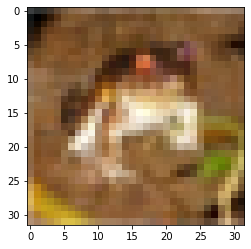

In [35]:
print(y_train_cifar10[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar10[0]), cmap=plt.cm.binary)

## CIFAR10 classes: 0-4

### reshape dataset

In [36]:
indexes_train = np.zeros(x_train_cifar10.shape[0], dtype=bool)
indexes_train[y_train_cifar10<=4] = True
x_train_cifar10_0_4 = x_train_cifar10[indexes_train==True]
y_train_cifar10_0_4 = y_train_cifar10[indexes_train==True]


4


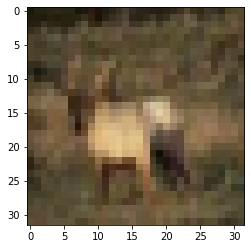

In [37]:
print(y_train_cifar10_0_4[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar10_0_4[0]), cmap=plt.cm.binary)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [38]:
x_train_cifar10_0_4 = x_train_cifar10_0_4.astype('float32')
x_train_cifar10_0_4 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR10 0-4'
epochs = 5
k_fold(x_train_cifar10_0_4, y_train_cifar10_0_4, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3626 - accuracy: 0.4156
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0410 - accuracy: 0.5764
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9685 - accuracy: 0.6160
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.8643 - accuracy: 0.6667
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7587 - accuracy: 0.7044
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
73/73 [==============================] - 1s 4ms/step - loss: 1.2068 - accuracy: 0.5334
Epoch 2/5
73/73 [==============================] - 0s 3ms/step - loss: 0.8867 - accuracy: 0.6724
Epoch 3/5
73/73 [==============================] - 0s 3ms/step - loss: 0.7768 - accuracy: 0.7103
Epoch 4/5
73/73 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.7499
Epoch 5/5
73/73 [==============================] - 0s 3ms/step - loss: 0.5767 - accuracy: 0.7882
Epoch 1/5
102/102 [==============================] - 1s 3ms/step - loss: 1.1469 - accuracy: 0.5623
Epoch 2/5
102/102 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.7461
Epoch 3/5
102/102 [==============================] - 0s 3ms/step - loss: 0.5956 - accuracy: 0.7870
Epoch 4/5
102/102 [==============================] - 0s 3ms/step - loss: 0.5462 - accuracy: 0.8070
Epoch 5/5
102/102 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.8239

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.4175 - accuracy: 0.4031
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0838 - accuracy: 0.5578
Epoch 3/5
71/71 [==============================] - 0s 3ms/step - loss: 0.9585 - accuracy: 0.6160
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8934 - accuracy: 0.6329
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8481 - accuracy: 0.6489
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
70/70 [==============================] - 1s 3ms/step - loss: 1.2008 - accuracy: 0.5296
Epoch 2/5
70/70 [==============================] - 0s 4ms/step - loss: 0.8113 - accuracy: 0.6901
Epoch 3/5
70/70 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.7471
Epoch 4/5
70/70 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.7587
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 0.5711 - accuracy: 0.7969
Epoch 1/5
99/99 [==============================] - 1s 4ms/step - loss: 1.1126 - accuracy: 0.5861
Epoch 2/5
99/99 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.7643
Epoch 3/5
99/99 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.8119
Epoch 4/5
99/99 [==============================] - 0s 3ms/step - loss: 0.5214 - accuracy: 0.8170
Epoch 5/5
99/99 [==============================] - 0s 3ms/step - loss: 0.4626 - accuracy: 0.8374

num_of_students: 3
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3597 - accuracy: 0.4196
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0496 - accuracy: 0.5707
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9019 - accuracy: 0.6391
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8097 - accuracy: 0.6720
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7449 - accuracy: 0.7067
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
77/77 [==============================] - 1s 4ms/step - loss: 1.1634 - accuracy: 0.5365
Epoch 2/5
77/77 [==============================] - 0s 4ms/step - loss: 0.8069 - accuracy: 0.7031
Epoch 3/5
77/77 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.7470
Epoch 4/5
77/77 [==============================] - 0s 4ms/step - loss: 0.5915 - accuracy: 0.7821
Epoch 5/5
77/77 [==============================] - 0s 3ms/step - loss: 0.5573 - accuracy: 0.7878
Epoch 1/5
108/108 [==============================] - 1s 4ms/step - loss: 1.0279 - accuracy: 0.6065
Epoch 2/5
108/108 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.7611
Epoch 3/5
108/108 [==============================] - 0s 3ms/step - loss: 0.5702 - accuracy: 0.8018
Epoch 4/5
108/108 [==============================] - 0s 3ms/step - loss: 0.5089 - accuracy: 0.8248
Epoch 5/5
108/108 [==============================] - 0s 3ms/step - loss: 0.4650 - accuracy: 0.8373

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3506 - accuracy: 0.4222
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0423 - accuracy: 0.5600
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9320 - accuracy: 0.6178
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8063 - accuracy: 0.6787
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7595 - accuracy: 0.6969
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
73/73 [==============================] - 1s 4ms/step - loss: 1.2925 - accuracy: 0.4836
Epoch 2/5
73/73 [==============================] - 0s 4ms/step - loss: 0.9084 - accuracy: 0.6634
Epoch 3/5
73/73 [==============================] - 0s 4ms/step - loss: 0.7420 - accuracy: 0.7191
Epoch 4/5
73/73 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.7636
Epoch 5/5
73/73 [==============================] - 0s 4ms/step - loss: 0.5815 - accuracy: 0.7857
Epoch 1/5
104/104 [==============================] - 1s 4ms/step - loss: 1.0485 - accuracy: 0.5920
Epoch 2/5
104/104 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.7586
Epoch 3/5
104/104 [==============================] - 0s 4ms/step - loss: 0.5861 - accuracy: 0.7968
Epoch 4/5
104/104 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.8358
Epoch 5/5
104/104 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8533

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3943 - accuracy: 0.3924
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0626 - accuracy: 0.5707
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9330 - accuracy: 0.6218
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8458 - accuracy: 0.6609
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7438 - accuracy: 0.7111
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
74/74 [==============================] - 1s 4ms/step - loss: 1.2034 - accuracy: 0.5360
Epoch 2/5
74/74 [==============================] - 0s 4ms/step - loss: 0.8781 - accuracy: 0.6644
Epoch 3/5
74/74 [==============================] - 0s 4ms/step - loss: 0.7252 - accuracy: 0.7335
Epoch 4/5
74/74 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.7318
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.7835
Epoch 1/5
103/103 [==============================] - 1s 4ms/step - loss: 1.0955 - accuracy: 0.5820
Epoch 2/5
103/103 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.7565
Epoch 3/5
103/103 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.7782
Epoch 4/5
103/103 [==============================] - 0s 4ms/step - loss: 0.5337 - accuracy: 0.8188
Epoch 5/5
103/103 [==============================] - 0s 4ms/step - loss: 0.4867 - accuracy: 0.8329

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.4467 - accuracy: 0.3636
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.1213 - accuracy: 0.5516
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9807 - accuracy: 0.5916
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.9012 - accuracy: 0.6418
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8374 - accuracy: 0.6609
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
73/73 [==============================] - 1s 4ms/step - loss: 1.2605 - accuracy: 0.5058
Epoch 2/5
73/73 [==============================] - 0s 4ms/step - loss: 0.8760 - accuracy: 0.6713
Epoch 3/5
73/73 [==============================] - 0s 4ms/step - loss: 0.7557 - accuracy: 0.7185
Epoch 4/5
73/73 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.7434
Epoch 5/5
73/73 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.7675
Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 1.1251 - accuracy: 0.5659
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 0.7292 - accuracy: 0.7425
Epoch 3/5
101/101 [==============================] - 0s 4ms/step - loss: 0.5861 - accuracy: 0.8014
Epoch 4/5
101/101 [==============================] - 0s 3ms/step - loss: 0.5142 - accuracy: 0.8207
Epoch 5/5
101/101 [==============================] - 0s 4ms/step - loss: 0.4793 - accuracy: 0.8368

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.4798 - accuracy: 0.3724
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.1461 - accuracy: 0.5373
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0074 - accuracy: 0.5991
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9322 - accuracy: 0.6253
Epoch 5/5
71/71 [==============================] - 0s 3ms/step - loss: 0.8541 - accuracy: 0.6560
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
72/72 [==============================] - 1s 4ms/step - loss: 1.2447 - accuracy: 0.4978
Epoch 2/5
72/72 [==============================] - 0s 4ms/step - loss: 0.8636 - accuracy: 0.6760
Epoch 3/5
72/72 [==============================] - 0s 4ms/step - loss: 0.7590 - accuracy: 0.7208
Epoch 4/5
72/72 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.7458
Epoch 5/5
72/72 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.7730
Epoch 1/5
102/102 [==============================] - 1s 4ms/step - loss: 1.0247 - accuracy: 0.6131
Epoch 2/5
102/102 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.7568
Epoch 3/5
102/102 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.7849
Epoch 4/5
102/102 [==============================] - 0s 4ms/step - loss: 0.5505 - accuracy: 0.8153
Epoch 5/5
102/102 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.8359

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.4840 - accuracy: 0.3547
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.1558 - accuracy: 0.5276
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0288 - accuracy: 0.5813
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9565 - accuracy: 0.6147
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8812 - accuracy: 0.6511
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
67/67 [==============================] - 1s 4ms/step - loss: 1.3292 - accuracy: 0.4546
Epoch 2/5
67/67 [==============================] - 0s 4ms/step - loss: 0.9558 - accuracy: 0.6438
Epoch 3/5
67/67 [==============================] - 0s 4ms/step - loss: 0.8042 - accuracy: 0.7058
Epoch 4/5
67/67 [==============================] - 0s 4ms/step - loss: 0.7350 - accuracy: 0.7261
Epoch 5/5
67/67 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.7559
Epoch 1/5
95/95 [==============================] - 1s 4ms/step - loss: 1.2330 - accuracy: 0.4729
Epoch 2/5
95/95 [==============================] - 0s 4ms/step - loss: 0.7708 - accuracy: 0.7255
Epoch 3/5
95/95 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.7688
Epoch 4/5
95/95 [==============================] - 0s 4ms/step - loss: 0.5751 - accuracy: 0.7933
Epoch 5/5
95/95 [==============================] - 0s 4ms/step - loss: 0.5144 - accuracy: 0.8231

num_of_students: 3
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3280 - accuracy: 0.4409
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0379 - accuracy: 0.5938
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9028 - accuracy: 0.6436
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8361 - accuracy: 0.6587
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7806 - accuracy: 0.6911
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
75/75 [==============================] - 1s 4ms/step - loss: 1.2371 - accuracy: 0.5115
Epoch 2/5
75/75 [==============================] - 0s 4ms/step - loss: 0.8420 - accuracy: 0.6951
Epoch 3/5
75/75 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.7472
Epoch 4/5
75/75 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.7635
Epoch 5/5
75/75 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.7673
Epoch 1/5
104/104 [==============================] - 1s 4ms/step - loss: 1.1089 - accuracy: 0.5605
Epoch 2/5
104/104 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.7548
Epoch 3/5
104/104 [==============================] - 0s 4ms/step - loss: 0.5619 - accuracy: 0.8087
Epoch 4/5
104/104 [==============================] - 0s 4ms/step - loss: 0.4876 - accuracy: 0.8365
Epoch 5/5
104/104 [==============================] - 0s 4ms/step - loss: 0.4592 - accuracy: 0.8422

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.4478 - accuracy: 0.3693
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.1556 - accuracy: 0.5138
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.6098
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9035 - accuracy: 0.6427
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8232 - accuracy: 0.6724
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.1849 - accuracy: 0.5342
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8762 - accuracy: 0.6709
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7429 - accuracy: 0.7270
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.7622
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.5784 - accuracy: 0.7891
Epoch 1/5
103/103 [==============================] - 1s 4ms/step - loss: 0.9984 - accuracy: 0.6208
Epoch 2/5
103/103 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.7531
Epoch 3/5
103/103 [==============================] - 0s 4ms/step - loss: 0.5777 - accuracy: 0.7965
Epoch 4/5
103/103 [==============================] - 0s 4ms/step - loss: 0.5225 - accuracy: 0.8182
Epoch 5/5
103/103 [==============================] - 0s 4ms/step - loss: 0.4740 - accuracy: 0.8335

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## CIFAR10 classes: 5-9

### reshape dataset

In [39]:
indexes_train = np.zeros(x_train_cifar10.shape[0], dtype=bool)
indexes_train[y_train_cifar10>=5] = True
x_train_cifar10_5_9 = x_train_cifar10[indexes_train==True]
y_train_cifar10_5_9 = y_train_cifar10[indexes_train==True]


rescale labels to start from 0

In [40]:
y_train_cifar10_5_9 = y_train_cifar10_5_9 - 5

1


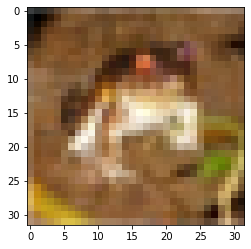

In [41]:
print(y_train_cifar10_5_9[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar10_5_9[0]), cmap=plt.cm.binary)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [42]:
x_train_cifar10_5_9 = x_train_cifar10_5_9.astype('float32')
x_train_cifar10_5_9 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR10 5_9'
epochs = 5
k_fold(x_train_cifar10_5_9, y_train_cifar10_5_9, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
71/71 [==============================] - 3s 5ms/step - loss: 1.3193 - accuracy: 0.4507
Epoch 2/5
71/71 [==============================] - 0s 3ms/step - loss: 0.9643 - accuracy: 0.6467
Epoch 3/5
71/71 [==============================] - 0s 3ms/step - loss: 0.7859 - accuracy: 0.7053
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.7489
Epoch 5/5
71/71 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.7676
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
82/82 [==============================] - 1s 5ms/step - loss: 1.1272 - accuracy: 0.5412
Epoch 2/5
82/82 [==============================] - 0s 4ms/step - loss: 0.7690 - accuracy: 0.7151
Epoch 3/5
82/82 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.7651
Epoch 4/5
82/82 [==============================] - 0s 3ms/step - loss: 0.5958 - accuracy: 0.7872
Epoch 5/5
82/82 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.8211
Epoch 1/5
116/116 [==============================] - 1s 4ms/step - loss: 1.0103 - accuracy: 0.6065
Epoch 2/5
116/116 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.7835
Epoch 3/5
116/116 [==============================] - 0s 3ms/step - loss: 0.5008 - accuracy: 0.8284
Epoch 4/5
116/116 [==============================] - 0s 3ms/step - loss: 0.4195 - accuracy: 0.8570
Epoch 5/5
116/116 [==============================] - 0s 3ms/step - loss: 0.4124 - accuracy: 0.8611

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2761 - accuracy: 0.4707
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9351 - accuracy: 0.6484
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7553 - accuracy: 0.7178
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.7622
Epoch 5/5
71/71 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.7982
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
82/82 [==============================] - 1s 4ms/step - loss: 1.1863 - accuracy: 0.4968
Epoch 2/5
82/82 [==============================] - 0s 4ms/step - loss: 0.7334 - accuracy: 0.7360
Epoch 3/5
82/82 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.7856
Epoch 4/5
82/82 [==============================] - 0s 3ms/step - loss: 0.5185 - accuracy: 0.8158
Epoch 5/5
82/82 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8426
Epoch 1/5
119/119 [==============================] - 1s 3ms/step - loss: 0.9435 - accuracy: 0.6400
Epoch 2/5
119/119 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.7811
Epoch 3/5
119/119 [==============================] - 0s 3ms/step - loss: 0.4748 - accuracy: 0.8348
Epoch 4/5
119/119 [==============================] - 0s 3ms/step - loss: 0.4090 - accuracy: 0.8597
Epoch 5/5
119/119 [==============================] - 0s 3ms/step - loss: 0.4033 - accuracy: 0.8584

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2991 - accuracy: 0.4658
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9272 - accuracy: 0.6413
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7371 - accuracy: 0.7347
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.7604
Epoch 5/5
71/71 [==============================] - 0s 3ms/step - loss: 0.5385 - accuracy: 0.8053
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
82/82 [==============================] - 1s 3ms/step - loss: 1.1987 - accuracy: 0.5011
Epoch 2/5
82/82 [==============================] - 0s 3ms/step - loss: 0.7786 - accuracy: 0.7084
Epoch 3/5
82/82 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.7559
Epoch 4/5
82/82 [==============================] - 0s 3ms/step - loss: 0.5449 - accuracy: 0.8031
Epoch 5/5
82/82 [==============================] - 0s 4ms/step - loss: 0.4680 - accuracy: 0.8287
Epoch 1/5
120/120 [==============================] - 1s 4ms/step - loss: 1.0450 - accuracy: 0.5867
Epoch 2/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.7465
Epoch 3/5
120/120 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.8064
Epoch 4/5
120/120 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.8334
Epoch 5/5
120/120 [==============================] - 0s 3ms/step - loss: 0.4410 - accuracy: 0.8431

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3583 - accuracy: 0.4222
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 1.0318 - accuracy: 0.5862
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8415 - accuracy: 0.6787
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7706 - accuracy: 0.7173
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.7791
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
82/82 [==============================] - 1s 4ms/step - loss: 1.1048 - accuracy: 0.5431
Epoch 2/5
82/82 [==============================] - 0s 4ms/step - loss: 0.7524 - accuracy: 0.7192
Epoch 3/5
82/82 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.7838
Epoch 4/5
82/82 [==============================] - 0s 4ms/step - loss: 0.5380 - accuracy: 0.8131
Epoch 5/5
82/82 [==============================] - 0s 4ms/step - loss: 0.5192 - accuracy: 0.8104
Epoch 1/5
116/116 [==============================] - 1s 4ms/step - loss: 0.9211 - accuracy: 0.6510
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.5713 - accuracy: 0.7991
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4697 - accuracy: 0.8430
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.8701
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.3305 - accuracy: 0.8867

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2535 - accuracy: 0.4871
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9762 - accuracy: 0.6298
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8065 - accuracy: 0.7036
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.7498
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.5730 - accuracy: 0.7969
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
83/83 [==============================] - 1s 4ms/step - loss: 1.1114 - accuracy: 0.5437
Epoch 2/5
83/83 [==============================] - 0s 4ms/step - loss: 0.7099 - accuracy: 0.7413
Epoch 3/5
83/83 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.8032
Epoch 4/5
83/83 [==============================] - 0s 4ms/step - loss: 0.4961 - accuracy: 0.8294
Epoch 5/5
83/83 [==============================] - 0s 4ms/step - loss: 0.4022 - accuracy: 0.8541
Epoch 1/5
120/120 [==============================] - 1s 4ms/step - loss: 1.0276 - accuracy: 0.5975
Epoch 2/5
120/120 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.7895
Epoch 3/5
120/120 [==============================] - 0s 4ms/step - loss: 0.4833 - accuracy: 0.8360
Epoch 4/5
120/120 [==============================] - 0s 4ms/step - loss: 0.4308 - accuracy: 0.8449
Epoch 5/5
120/120 [==============================] - 0s 4ms/step - loss: 0.3458 - accuracy: 0.8805

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2778 - accuracy: 0.4676
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9566 - accuracy: 0.6369
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8383 - accuracy: 0.6787
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7236 - accuracy: 0.7471
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.7569
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
79/79 [==============================] - 1s 4ms/step - loss: 1.0846 - accuracy: 0.5820
Epoch 2/5
79/79 [==============================] - 0s 4ms/step - loss: 0.7780 - accuracy: 0.7171
Epoch 3/5
79/79 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.7751
Epoch 4/5
79/79 [==============================] - 0s 4ms/step - loss: 0.5321 - accuracy: 0.8105
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.4581 - accuracy: 0.8435
Epoch 1/5
116/116 [==============================] - 1s 4ms/step - loss: 0.9696 - accuracy: 0.6304
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.7909
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4770 - accuracy: 0.8384
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4356 - accuracy: 0.8497
Epoch 5/5
116/116 [==============================] - 0s 3ms/step - loss: 0.3734 - accuracy: 0.8702

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2644 - accuracy: 0.4920
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9281 - accuracy: 0.6533
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7909 - accuracy: 0.7067
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6672 - accuracy: 0.7653
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.5933 - accuracy: 0.7773
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
82/82 [==============================] - 1s 4ms/step - loss: 1.1285 - accuracy: 0.5522
Epoch 2/5
82/82 [==============================] - 0s 4ms/step - loss: 0.7406 - accuracy: 0.7310
Epoch 3/5
82/82 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.7645
Epoch 4/5
82/82 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.8185
Epoch 5/5
82/82 [==============================] - 0s 4ms/step - loss: 0.4687 - accuracy: 0.8328
Epoch 1/5
119/119 [==============================] - 1s 4ms/step - loss: 1.0277 - accuracy: 0.5959
Epoch 2/5
119/119 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.7839
Epoch 3/5
119/119 [==============================] - 0s 4ms/step - loss: 0.4852 - accuracy: 0.8374
Epoch 4/5
119/119 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.8579
Epoch 5/5
119/119 [==============================] - 0s 3ms/step - loss: 0.3849 - accuracy: 0.8640

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3458 - accuracy: 0.4333
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9957 - accuracy: 0.6164
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8338 - accuracy: 0.6871
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.7453
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.5830 - accuracy: 0.7884
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 1.1030 - accuracy: 0.5749
Epoch 2/5
80/80 [==============================] - 0s 4ms/step - loss: 0.7354 - accuracy: 0.7336
Epoch 3/5
80/80 [==============================] - 0s 4ms/step - loss: 0.5892 - accuracy: 0.7994
Epoch 4/5
80/80 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.8235
Epoch 5/5
80/80 [==============================] - 0s 4ms/step - loss: 0.4656 - accuracy: 0.8428
Epoch 1/5
115/115 [==============================] - 1s 4ms/step - loss: 0.9030 - accuracy: 0.6676
Epoch 2/5
115/115 [==============================] - 0s 4ms/step - loss: 0.5809 - accuracy: 0.8002
Epoch 3/5
115/115 [==============================] - 0s 4ms/step - loss: 0.4614 - accuracy: 0.8410
Epoch 4/5
115/115 [==============================] - 0s 4ms/step - loss: 0.3895 - accuracy: 0.8712
Epoch 5/5
115/115 [==============================] - 0s 4ms/step - loss: 0.3368 - accuracy: 0.8834

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.3262 - accuracy: 0.4653
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9960 - accuracy: 0.6298
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8077 - accuracy: 0.7080
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.7449
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.7836
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
80/80 [==============================] - 1s 4ms/step - loss: 1.1631 - accuracy: 0.5302
Epoch 2/5
80/80 [==============================] - 0s 4ms/step - loss: 0.7697 - accuracy: 0.7127
Epoch 3/5
80/80 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.7899
Epoch 4/5
80/80 [==============================] - 0s 4ms/step - loss: 0.5128 - accuracy: 0.8246
Epoch 5/5
80/80 [==============================] - 0s 4ms/step - loss: 0.4416 - accuracy: 0.8475
Epoch 1/5
116/116 [==============================] - 1s 4ms/step - loss: 0.9707 - accuracy: 0.6288
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.5968 - accuracy: 0.7918
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.8373
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4098 - accuracy: 0.8614
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.3462 - accuracy: 0.8874

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
71/71 [==============================] - 1s 4ms/step - loss: 1.2689 - accuracy: 0.4796
Epoch 2/5
71/71 [==============================] - 0s 4ms/step - loss: 0.9915 - accuracy: 0.6129
Epoch 3/5
71/71 [==============================] - 0s 4ms/step - loss: 0.8286 - accuracy: 0.6942
Epoch 4/5
71/71 [==============================] - 0s 4ms/step - loss: 0.7362 - accuracy: 0.7364
Epoch 5/5
71/71 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.7520
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
79/79 [==============================] - 1s 4ms/step - loss: 1.1013 - accuracy: 0.5690
Epoch 2/5
79/79 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.7594
Epoch 3/5
79/79 [==============================] - 0s 4ms/step - loss: 0.6027 - accuracy: 0.7957
Epoch 4/5
79/79 [==============================] - 0s 4ms/step - loss: 0.5079 - accuracy: 0.8264
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.4277 - accuracy: 0.8540
Epoch 1/5
116/116 [==============================] - 1s 4ms/step - loss: 0.8873 - accuracy: 0.6667
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.5309 - accuracy: 0.8165
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.4086 - accuracy: 0.8612
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.8756
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.9019

num_of_students: 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# CIFAR100

## Import the cifar100 dataset

In [43]:
(x_train_cifar100, y_train_cifar100), (x_test_cifar100, y_test_cifar100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 2s 0us/step


In [44]:
x_train_cifar100.shape

(50000, 32, 32, 3)

In [45]:
y_train_cifar100 = np.squeeze(y_train_cifar100)
y_train_cifar100.shape

(50000,)

19


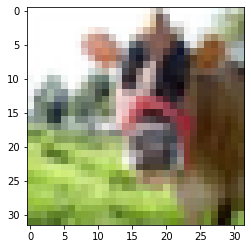

In [46]:
print(y_train_cifar100[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar100[0]), cmap=plt.cm.binary)

## CIFAR100 classes: 0-9

### reshape dataset

In [47]:
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train[y_train_cifar100<=9] = True
x_train_cifar0_9 = x_train_cifar100[indexes_train==True]
y_train_cifar0_9 = y_train_cifar100[indexes_train==True]


0


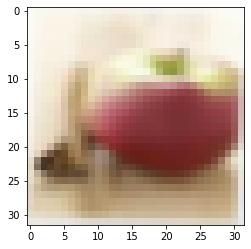

In [48]:
print(y_train_cifar0_9[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar0_9[0]), cmap=plt.cm.binary)

In [49]:
x_train_cifar0_9.shape

(5000, 32, 32, 3)

In [50]:
y_train_cifar0_9.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [51]:
x_train_cifar0_9 = x_train_cifar0_9.astype('float32')
x_train_cifar0_9 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 0-9'
epochs = 2
k_fold(x_train_cifar0_9, y_train_cifar0_9, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3111 - accuracy: 0.1311
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2098 - accuracy: 0.1822
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3382 - accuracy: 0.1033
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2404 - accuracy: 0.1500
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3183 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2227 - accuracy: 0.2367

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3228 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2282 - accuracy: 0.2067
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3062 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1755 - accuracy: 0.2700
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3279 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2531 - accuracy: 0.2000

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3199 - accuracy: 0.0911
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2497 - accuracy: 0.1844
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3032 - accuracy: 0.1300
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1458 - accuracy: 0.2133
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3725 - accuracy: 0.1159
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2518 - accuracy: 0.2318

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3352 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2558 - accuracy: 0.1967
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3394 - accuracy: 0.1000
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2460 - accuracy: 0.2000
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3148 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2139 - accuracy: 0.2100

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3110 - accuracy: 0.1111
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2186 - accuracy: 0.1956
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3344 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2501 - accuracy: 0.1533
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3318 - accuracy: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2523 - accuracy: 0.2000

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3132 - accuracy: 0.1300
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2300 - accuracy: 0.2433
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3175 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2124 - accuracy: 0.2300
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3302 - accuracy: 0.1291
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2139 - accuracy: 0.2318

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2875 - accuracy: 0.1356
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1434 - accuracy: 0.2000
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3478 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2524 - accuracy: 0.1533
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3307 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2590 - accuracy: 0.1933

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3472 - accuracy: 0.1033
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2566 - accuracy: 0.1533
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3156 - accuracy: 0.1033
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2246 - accuracy: 0.1867
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3616 - accuracy: 0.0900
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2610 - accuracy: 0.1300

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2861 - accuracy: 0.1578
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2040 - accuracy: 0.1911
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3004 - accuracy: 0.1700
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1912 - accuracy: 0.2367
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3130 - accuracy: 0.1130
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1868 - accuracy: 0.3023

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3186 - accuracy: 0.1467
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1841 - accuracy: 0.3200
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2932 - accuracy: 0.1533
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1197 - accuracy: 0.2867
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2981 - accuracy: 0.1392
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1193 - accuracy: 0.2751

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3096 - accuracy: 0.1111
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1686 - accuracy: 0.2444
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3079 - accuracy: 0.1633
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1664 - accuracy: 0.2700
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3231 - accuracy: 0.1533
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2198 - accuracy: 0.2167

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3189 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2025 - accuracy: 0.3067
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3165 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1726 - accuracy: 0.2700
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3177 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.2733

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 8ms/step - loss: 2.3269 - accuracy: 0.1556
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2600 - accuracy: 0.1378
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2959 - accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0917 - accuracy: 0.2867
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3128 - accuracy: 0.1743
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0953 - accuracy: 0.3224

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3192 - accuracy: 0.1267
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1491 - accuracy: 0.2667
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2969 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0856 - accuracy: 0.3033
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3138 - accuracy: 0.1513
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1465 - accuracy: 0.2500

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3177 - accuracy: 0.0889
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2302 - accuracy: 0.2267
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3309 - accuracy: 0.1100
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1938 - accuracy: 0.2367
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3461 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2593 - accuracy: 0.2500

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3389 - accuracy: 0.1100
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2309 - accuracy: 0.1933
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3330 - accuracy: 0.1267
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2074 - accuracy: 0.2267
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3134 - accuracy: 0.1300
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1848 - accuracy: 0.2100

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3218 - accuracy: 0.1578
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2375 - accuracy: 0.1622
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3089 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1849 - accuracy: 0.3000
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2651 - accuracy: 0.2333
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1102 - accuracy: 0.3133

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3106 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1541 - accuracy: 0.2633
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3186 - accuracy: 0.1561
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1934 - accuracy: 0.2392
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3222 - accuracy: 0.1329
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2008 - accuracy: 0.2492

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3028 - accuracy: 0.1156
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1987 - accuracy: 0.1711
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3019 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1627 - accuracy: 0.2467
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2756 - accuracy: 0.1927
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0637 - accuracy: 0.2724

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3009 - accuracy: 0.1633
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1915 - accuracy: 0.2567
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3254 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2274 - accuracy: 0.2167
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3098 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1894 - accuracy: 0.2433

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 10-19

### reshape dataset

In [52]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=10] = True
indexes_train_2[y_train_cifar100<=19] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar10_19 = x_train_cifar100[indexes_train==True]
y_train_cifar10_19 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [53]:
y_train_cifar10_19 = y_train_cifar10_19 - 10

9


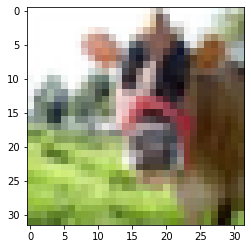

In [54]:
print(y_train_cifar10_19[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar10_19[0]), cmap=plt.cm.binary)

In [55]:
x_train_cifar10_19.shape

(5000, 32, 32, 3)

In [56]:
y_train_cifar10_19.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [57]:
x_train_cifar10_19 = x_train_cifar10_19.astype('float32')
x_train_cifar10_19 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 10-19'
epochs = 2
k_fold(x_train_cifar10_19, y_train_cifar10_19, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 29s 10ms/step - loss: 2.3101 - accuracy: 0.1400
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2054 - accuracy: 0.1822
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 14ms/step - loss: 2.3104 - accuracy: 0.1023
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1949 - accuracy: 0.2442
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3152 - accuracy: 0.1419
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2160 - accuracy: 0.2508

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2894 - accuracy: 0.1584
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1752 - accuracy: 0.2310
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3175 - accuracy: 0.1584
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2291 - accuracy: 0.2541
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3804 - accuracy: 0.1353
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2654 - accuracy: 0.1716

threshol

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2965 - accuracy: 0.1178
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1411 - accuracy: 0.2222
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3180 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2080 - accuracy: 0.2267
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3093 - accuracy: 0.1633
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1911 - accuracy: 0.2300

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3077 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2435 - accuracy: 0.2533
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3159 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2305 - accuracy: 0.1600
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3178 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 9ms/step - loss: 2.2176 - accuracy: 0.2867

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2856 - accuracy: 0.1467
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1173 - accuracy: 0.2733
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2922 - accuracy: 0.1414
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1691 - accuracy: 0.2566
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2794 - accuracy: 0.1546
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0976 - accuracy: 0.2730

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3331 - accuracy: 0.0954
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2225 - accuracy: 0.1776
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3003 - accuracy: 0.1842
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1765 - accuracy: 0.2796
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3165 - accuracy: 0.1645
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1834 - accuracy: 0.2500

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3114 - accuracy: 0.1289
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1857 - accuracy: 0.2444
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3391 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2360 - accuracy: 0.1567
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3044 - accuracy: 0.2033
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2160 - accuracy: 0.1800

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3306 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2317 - accuracy: 0.1867
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3193 - accuracy: 0.1433
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2482 - accuracy: 0.2100
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3255 - accuracy: 0.1567
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2475 - accuracy: 0.1367

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2993 - accuracy: 0.1089
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1193 - accuracy: 0.2133
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3110 - accuracy: 0.1386
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1865 - accuracy: 0.2640
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2830 - accuracy: 0.1584
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0962 - accuracy: 0.3102

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3210 - accuracy: 0.1320
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2093 - accuracy: 0.2442
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2898 - accuracy: 0.1518
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1583 - accuracy: 0.3168
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2951 - accuracy: 0.1947
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1085 - accuracy: 0.3003

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2751 - accuracy: 0.1400
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1472 - accuracy: 0.2356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2874 - accuracy: 0.1800
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1630 - accuracy: 0.2433
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3089 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2256 - accuracy: 0.2567

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3149 - accuracy: 0.1500
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2331 - accuracy: 0.2567
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2927 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1475 - accuracy: 0.2800
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3145 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2009 - accuracy: 0.2533

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3113 - accuracy: 0.1022
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1263 - accuracy: 0.2156
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3556 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2119 - accuracy: 0.3067
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3153 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2084 - accuracy: 0.1700

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3361 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2166 - accuracy: 0.2700
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3003 - accuracy: 0.1567
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1566 - accuracy: 0.2567
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3512 - accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2594 - accuracy: 0.1467

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3103 - accuracy: 0.1489
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1410 - accuracy: 0.2600
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3280 - accuracy: 0.1661
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1902 - accuracy: 0.2392
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2904 - accuracy: 0.1827
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1573 - accuracy: 0.2425

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3018 - accuracy: 0.1495
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2074 - accuracy: 0.2292
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3110 - accuracy: 0.1728
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2413 - accuracy: 0.2425
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2976 - accuracy: 0.1628
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1265 - accuracy: 0.2757

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3146 - accuracy: 0.1333
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2610 - accuracy: 0.1622
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3165 - accuracy: 0.1267
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2272 - accuracy: 0.2867
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3094 - accuracy: 0.1533
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1978 - accuracy: 0.2867

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3079 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.2867
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.2958 - accuracy: 0.1433
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2052 - accuracy: 0.2267
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3016 - accuracy: 0.1300
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1980 - accuracy: 0.2533

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3342 - accuracy: 0.1022
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2181 - accuracy: 0.2311
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2880 - accuracy: 0.1767
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1646 - accuracy: 0.2700
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3138 - accuracy: 0.1600
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1769 - accuracy: 0.2467

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3230 - accuracy: 0.1767
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2343 - accuracy: 0.2433
Epoch 1/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2806 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1610 - accuracy: 0.2300
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2990 - accuracy: 0.1567
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1982 - accuracy: 0.2500

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 20-29

### reshape dataset

In [58]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=20] = True
indexes_train_2[y_train_cifar100<=29] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar20_29 = x_train_cifar100[indexes_train==True]
y_train_cifar20_29 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [59]:
y_train_cifar20_29 = y_train_cifar20_29 - 20

9


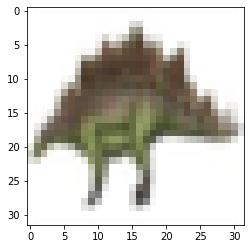

In [60]:
print(y_train_cifar20_29[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar20_29[0]), cmap=plt.cm.binary)

In [61]:
x_train_cifar20_29.shape

(5000, 32, 32, 3)

In [62]:
y_train_cifar20_29.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [63]:
x_train_cifar20_29 = x_train_cifar20_29.astype('float32')
x_train_cifar20_29 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 20-29'
epochs = 2
k_fold(x_train_cifar20_29, y_train_cifar20_29, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3017 - accuracy: 0.1400
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1769 - accuracy: 0.2067
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 8ms/step - loss: 2.3197 - accuracy: 0.1000
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2218 - accuracy: 0.1567
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3225 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2509 - accuracy: 0.1733

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3078 - accuracy: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2250 - accuracy: 0.1500
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3080 - accuracy: 0.1367
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2386 - accuracy: 0.1467
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3120 - accuracy: 0.1000
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2314 - accuracy: 0.1767

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2976 - accuracy: 0.1089
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2014 - accuracy: 0.2022
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2994 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2002 - accuracy: 0.1933
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3402 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2537 - accuracy: 0.1733

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3193 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2329 - accuracy: 0.1833
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2812 - accuracy: 0.1633
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1612 - accuracy: 0.2167
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2875 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2441 - accuracy: 0.1333

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3444 - accuracy: 0.1378
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2288 - accuracy: 0.1844
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3242 - accuracy: 0.1467
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2365 - accuracy: 0.1800
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3030 - accuracy: 0.1267
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2164 - accuracy: 0.1733

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3321 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2789 - accuracy: 0.1400
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3275 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2361 - accuracy: 0.1767
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3252 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2210 - accuracy: 0.2067

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3247 - accuracy: 0.1000
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2510 - accuracy: 0.1378
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2902 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1639 - accuracy: 0.2233
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2991 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2587 - accuracy: 0.1200

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3553 - accuracy: 0.1300
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2714 - accuracy: 0.1367
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3116 - accuracy: 0.1100
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2239 - accuracy: 0.1733
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3264 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2564 - accuracy: 0.1800

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3160 - accuracy: 0.1356
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2505 - accuracy: 0.1667
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3289 - accuracy: 0.1100
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2137 - accuracy: 0.1833
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2984 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1888 - accuracy: 0.1867

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3138 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2224 - accuracy: 0.1733
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3199 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2005 - accuracy: 0.1967
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3609 - accuracy: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2383 - accuracy: 0.1533

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3150 - accuracy: 0.0978
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2016 - accuracy: 0.2156
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3342 - accuracy: 0.1030
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2334 - accuracy: 0.1927
Epoch 1/2
10/10 [==============================] - 1s 9ms/step - loss: 2.3330 - accuracy: 0.1096
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.2093

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3247 - accuracy: 0.1262
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2262 - accuracy: 0.1429
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3397 - accuracy: 0.1130
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2448 - accuracy: 0.1329
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3085 - accuracy: 0.1329
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1818 - accuracy: 0.2027

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3167 - accuracy: 0.1244
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2239 - accuracy: 0.2578
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3278 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2484 - accuracy: 0.1300
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3109 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1989 - accuracy: 0.1700

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 0s 6ms/step - loss: 2.3189 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2342 - accuracy: 0.1467
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3083 - accuracy: 0.1333
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2348 - accuracy: 0.1500
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3269 - accuracy: 0.0967
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2473 - accuracy: 0.2033

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3321 - accuracy: 0.1200
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2060 - accuracy: 0.2267
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3378 - accuracy: 0.1133
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2449 - accuracy: 0.2067
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3249 - accuracy: 0.1067
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2348 - accuracy: 0.2100

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3219 - accuracy: 0.0867
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1970 - accuracy: 0.1800
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3078 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2497 - accuracy: 0.1333
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3592 - accuracy: 0.1267
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2735 - accuracy: 0.1233

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3090 - accuracy: 0.1289
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.2378 - accuracy: 0.1356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3431 - accuracy: 0.0700
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2678 - accuracy: 0.1633
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3093 - accuracy: 0.1100
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2006 - accuracy: 0.1767

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3115 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2238 - accuracy: 0.2200
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3787 - accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2742 - accuracy: 0.1767
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3232 - accuracy: 0.0867
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2544 - accuracy: 0.2033

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2890 - accuracy: 0.1133
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1518 - accuracy: 0.2067
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 9ms/step - loss: 2.3371 - accuracy: 0.1167
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1867
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2979 - accuracy: 0.1567
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2104 - accuracy: 0.2000

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3093 - accuracy: 0.1233
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2035 - accuracy: 0.2300
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3242 - accuracy: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2465 - accuracy: 0.1833
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3313 - accuracy: 0.0867
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.2638 - accuracy: 0.1300

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 30-39

### reshape dataset

In [64]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=30] = True
indexes_train_2[y_train_cifar100<=39] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar30_39 = x_train_cifar100[indexes_train==True]
y_train_cifar30_39 = y_train_cifar100[indexes_train==True]

In [65]:
y_train_cifar30_39 = y_train_cifar30_39 - 30

1


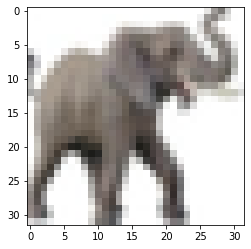

In [66]:
print(y_train_cifar30_39[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar30_39[0]), cmap=plt.cm.binary)

In [67]:
x_train_cifar30_39.shape

(5000, 32, 32, 3)

In [68]:
y_train_cifar30_39.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [69]:
x_train_cifar30_39 = x_train_cifar30_39.astype('float32')
x_train_cifar30_39 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 30-39'
epochs = 2
k_fold(x_train_cifar30_39, y_train_cifar30_39, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2647 - accuracy: 0.1867
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0397 - accuracy: 0.2533
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 15ms/step - loss: 2.2953 - accuracy: 0.1624
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0843 - accuracy: 0.2293
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2472 - accuracy: 0.1840
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9642 - accuracy: 0.3145

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.2453 - accuracy: 0.1815
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0151 - accuracy: 0.2834
Epoch 1/2
11/11 [==============================] - 1s 14ms/step - loss: 2.1991 - accuracy: 0.2124
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9367 - accuracy: 0.2950
Epoch 1/2
12/12 [==============================] - 1s 6ms/step - loss: 2.0844 - accuracy: 0.2717
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.7786 - accuracy: 0.3478

thresho

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2840 - accuracy: 0.1422
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0690 - accuracy: 0.2200
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3249 - accuracy: 0.1546
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0751 - accuracy: 0.2618
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2573 - accuracy: 0.2110
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9380 - accuracy: 0.3211

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2820 - accuracy: 0.1546
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0792 - accuracy: 0.2397
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2741 - accuracy: 0.1829
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9863 - accuracy: 0.2988
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1462 - accuracy: 0.2102
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8913 - accuracy: 0.3324

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2947 - accuracy: 0.1622
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0734 - accuracy: 0.2244
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2037 - accuracy: 0.1881
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9840 - accuracy: 0.3354
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2283 - accuracy: 0.1939
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9719 - accuracy: 0.3000

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2851 - accuracy: 0.1944
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0763 - accuracy: 0.2884
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2457 - accuracy: 0.1935
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0144 - accuracy: 0.2470
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1745 - accuracy: 0.2141
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8864 - accuracy: 0.3724

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2658 - accuracy: 0.1644
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0434 - accuracy: 0.2911
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3014 - accuracy: 0.1199
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1535 - accuracy: 0.2240
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1622 - accuracy: 0.1846
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9486 - accuracy: 0.3446

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 0s 7ms/step - loss: 2.3029 - accuracy: 0.1388
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1411 - accuracy: 0.1735
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2489 - accuracy: 0.1804
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 2.0210 - accuracy: 0.2966
Epoch 1/2
12/12 [==============================] - 1s 6ms/step - loss: 2.1585 - accuracy: 0.2254
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.9439 - accuracy: 0.2930

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2844 - accuracy: 0.1289
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0769 - accuracy: 0.2533
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2792 - accuracy: 0.1626
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0614 - accuracy: 0.3190
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2207 - accuracy: 0.2377
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9502 - accuracy: 0.2870

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.3469 - accuracy: 0.1104
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.2427 - accuracy: 0.1748
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2459 - accuracy: 0.1682
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0402 - accuracy: 0.2416
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1996 - accuracy: 0.2083
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8917 - accuracy: 0.3306

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2761 - accuracy: 0.1533
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0824 - accuracy: 0.2644
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3172 - accuracy: 0.1290
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0769 - accuracy: 0.2323
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2612 - accuracy: 0.1801
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0383 - accuracy: 0.2671

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3359 - accuracy: 0.1226
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2410 - accuracy: 0.2032
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2955 - accuracy: 0.1645
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1216 - accuracy: 0.1871
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2996 - accuracy: 0.1266
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0331 - accuracy: 0.3070

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3084 - accuracy: 0.1422
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1413 - accuracy: 0.2400
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3207 - accuracy: 0.1397
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1165 - accuracy: 0.2508
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2675 - accuracy: 0.1774
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9930 - accuracy: 0.2875

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3028 - accuracy: 0.1492
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0747 - accuracy: 0.2540
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2512 - accuracy: 0.1489
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0141 - accuracy: 0.2249
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2025 - accuracy: 0.2064
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9061 - accuracy: 0.3227

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3013 - accuracy: 0.1467
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0579 - accuracy: 0.2778
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3014 - accuracy: 0.1294
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0953 - accuracy: 0.2621
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2898 - accuracy: 0.1887
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0807 - accuracy: 0.2547

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3141 - accuracy: 0.1392
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1649 - accuracy: 0.2395
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2904 - accuracy: 0.1613
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0764 - accuracy: 0.2290
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2705 - accuracy: 0.1858
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0515 - accuracy: 0.2632

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2873 - accuracy: 0.1311
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1089 - accuracy: 0.1933
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2870 - accuracy: 0.1672
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0233 - accuracy: 0.2340
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1668 - accuracy: 0.2413
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.8764 - accuracy: 0.3227

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2515 - accuracy: 0.1672
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9699 - accuracy: 0.2888
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2180 - accuracy: 0.2326
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9460 - accuracy: 0.2762
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1192 - accuracy: 0.2473
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7937 - accuracy: 0.3297

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2959 - accuracy: 0.1844
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0783 - accuracy: 0.2178
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2711 - accuracy: 0.1964
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0252 - accuracy: 0.2931
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1545 - accuracy: 0.2051
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.9101 - accuracy: 0.3419

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2673 - accuracy: 0.1934
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0381 - accuracy: 0.2447
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1962 - accuracy: 0.2085
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.9506 - accuracy: 0.3099
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1327 - accuracy: 0.2565
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8089 - accuracy: 0.3560

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 40-49

### reshape dataset

In [70]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=40] = True
indexes_train_2[y_train_cifar100<=49] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar40_49 = x_train_cifar100[indexes_train==True]
y_train_cifar40_49 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [71]:
y_train_cifar40_49 = y_train_cifar40_49 - 40

2


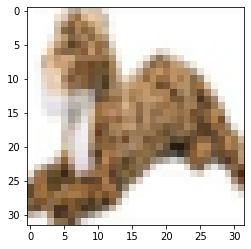

In [72]:
print(y_train_cifar40_49[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar40_49[0]), cmap=plt.cm.binary)

In [73]:
x_train_cifar40_49.shape

(5000, 32, 32, 3)

In [74]:
y_train_cifar40_49.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [75]:
x_train_cifar40_49 = x_train_cifar40_49.astype('float32')
x_train_cifar40_49 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 40-49'
epochs = 2
k_fold(x_train_cifar40_49, y_train_cifar40_49, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2734 - accuracy: 0.1778
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0408 - accuracy: 0.2733
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2933 - accuracy: 0.1283
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1343 - accuracy: 0.2763
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3077 - accuracy: 0.1382
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1330 - accuracy: 0.2599

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2976 - accuracy: 0.1546
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1243 - accuracy: 0.2303
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3134 - accuracy: 0.1294
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1168 - accuracy: 0.2524
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3052 - accuracy: 0.1392
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1466 - accuracy: 0.2233

threshold

ValueError: ignored

## CIFAR100 classes: 50-59

### reshape dataset

In [76]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=50] = True
indexes_train_2[y_train_cifar100<=59] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar50_59 = x_train_cifar100[indexes_train==True]
y_train_cifar50_59 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [77]:
y_train_cifar50_59 = y_train_cifar50_59 - 50

9


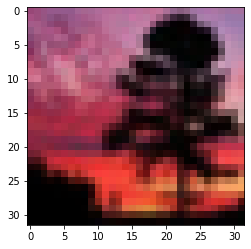

In [78]:
print(y_train_cifar50_59[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar50_59[0]), cmap=plt.cm.binary)

In [79]:
x_train_cifar50_59.shape

(5000, 32, 32, 3)

In [80]:
y_train_cifar50_59.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [81]:
x_train_cifar50_59 = x_train_cifar50_59.astype('float32')
x_train_cifar50_59 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 50-59'
epochs = 2
k_fold(x_train_cifar50_59, y_train_cifar50_59, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2151 - accuracy: 0.2000
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.9597 - accuracy: 0.2356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 13ms/step - loss: 2.2413 - accuracy: 0.2087
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9610 - accuracy: 0.2555
Epoch 1/2
11/11 [==============================] - 1s 14ms/step - loss: 2.2149 - accuracy: 0.2315
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9311 - accuracy: 0.2789

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2694 - accuracy: 0.1402
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 2.0366 - accuracy: 0.2181
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1087 - accuracy: 0.2170
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.7899 - accuracy: 0.3548
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0044 - accuracy: 0.2700
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7487 - accuracy: 0.3388

thresho

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2876 - accuracy: 0.1733
Epoch 2/2
15/15 [==============================] - 0s 8ms/step - loss: 1.9384 - accuracy: 0.3000
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1993 - accuracy: 0.1821
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9037 - accuracy: 0.2963
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.0780 - accuracy: 0.2515
Epoch 2/2
11/11 [==============================] - 0s 10ms/step - loss: 1.7533 - accuracy: 0.3402

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 6ms/step - loss: 2.2462 - accuracy: 0.1728
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9848 - accuracy: 0.2284
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2064 - accuracy: 0.2194
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8355 - accuracy: 0.2991
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 1.9836 - accuracy: 0.2865
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6030 - accuracy: 0.4350

threshol

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 2s 9ms/step - loss: 2.2409 - accuracy: 0.1911
Epoch 2/2
15/15 [==============================] - 0s 9ms/step - loss: 1.8778 - accuracy: 0.3111
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 11ms/step - loss: 2.2375 - accuracy: 0.1548
Epoch 2/2
10/10 [==============================] - 0s 15ms/step - loss: 2.0216 - accuracy: 0.2452
Epoch 1/2
11/11 [==============================] - 2s 14ms/step - loss: 2.1255 - accuracy: 0.2528
Epoch 2/2
11/11 [==============================] - 0s 13ms/step - loss: 1.8009 - accuracy: 0.3466

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 11ms/step - loss: 2.3177 - accuracy: 0.1581
Epoch 2/2
10/10 [==============================] - 0s 9ms/step - loss: 2.0568 - accuracy: 0.2032
Epoch 1/2
11/11 [==============================] - 1s 10ms/step - loss: 2.2447 - accuracy: 0.1951
Epoch 2/2
11/11 [==============================] - 0s 9ms/step - loss: 1.9307 - accuracy: 0.3232
Epoch 1/2
11/11 [==============================] - 1s 9ms/step - loss: 2.1418 - accuracy: 0.2265
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8096 - accuracy: 0.2971

thr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2018 - accuracy: 0.2178
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8520 - accuracy: 0.3067
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1765 - accuracy: 0.2018
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8352 - accuracy: 0.3180
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2019 - accuracy: 0.2017
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9181 - accuracy: 0.2767

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2674 - accuracy: 0.1743
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9914 - accuracy: 0.2905
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1606 - accuracy: 0.2393
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7909 - accuracy: 0.3276
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0599 - accuracy: 0.2676
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.6842 - accuracy: 0.3865

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2635 - accuracy: 0.1978
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.9896 - accuracy: 0.2578
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2137 - accuracy: 0.1815
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.8961 - accuracy: 0.3248
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1877 - accuracy: 0.1837
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8405 - accuracy: 0.3343

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2320 - accuracy: 0.1529
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9584 - accuracy: 0.2834
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1727 - accuracy: 0.2321
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8993 - accuracy: 0.3125
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1107 - accuracy: 0.2368
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7099 - accuracy: 0.4150

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2828 - accuracy: 0.1489
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0118 - accuracy: 0.3111
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3144 - accuracy: 0.1054
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1182 - accuracy: 0.2780
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3110 - accuracy: 0.1054
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1092 - accuracy: 0.2524

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2399 - accuracy: 0.1821
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9488 - accuracy: 0.3131
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1652 - accuracy: 0.2000
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8481 - accuracy: 0.3612
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.0983 - accuracy: 0.2206
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7921 - accuracy: 0.3725

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2231 - accuracy: 0.1622
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9499 - accuracy: 0.3000
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2836 - accuracy: 0.1410
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0085 - accuracy: 0.2949
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2103 - accuracy: 0.1867
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8668 - accuracy: 0.3795

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2901 - accuracy: 0.1410
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0282 - accuracy: 0.2724
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1560 - accuracy: 0.2340
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8158 - accuracy: 0.3921
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1376 - accuracy: 0.2536
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7655 - accuracy: 0.3761

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 9ms/step - loss: 2.2294 - accuracy: 0.1800
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8851 - accuracy: 0.3000
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1764 - accuracy: 0.2222
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8890 - accuracy: 0.3086
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1768 - accuracy: 0.1943
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8324 - accuracy: 0.3629

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2423 - accuracy: 0.1759
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9451 - accuracy: 0.3179
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1346 - accuracy: 0.2348
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8333 - accuracy: 0.3343
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0521 - accuracy: 0.3024
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6921 - accuracy: 0.4058

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2506 - accuracy: 0.1733
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9236 - accuracy: 0.2956
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2460 - accuracy: 0.1884
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9270 - accuracy: 0.3526
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1401 - accuracy: 0.2450
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7932 - accuracy: 0.3746

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2366 - accuracy: 0.1672
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9546 - accuracy: 0.3799
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2055 - accuracy: 0.1977
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8930 - accuracy: 0.3459
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0136 - accuracy: 0.2927
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6492 - accuracy: 0.4309

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2636 - accuracy: 0.1556
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9547 - accuracy: 0.3200
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2523 - accuracy: 0.2414
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.9540 - accuracy: 0.3132
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1289 - accuracy: 0.2769
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8388 - accuracy: 0.3844

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2068 - accuracy: 0.2500
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8876 - accuracy: 0.3103
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0678 - accuracy: 0.2880
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7617 - accuracy: 0.3653
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9347 - accuracy: 0.3537
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.5916 - accuracy: 0.4377

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 60-69

### reshape dataset

In [82]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=60] = True
indexes_train_2[y_train_cifar100<=69] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar60_69 = x_train_cifar100[indexes_train==True]
y_train_cifar60_69 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [83]:
y_train_cifar60_69 = y_train_cifar60_69 - 60

4


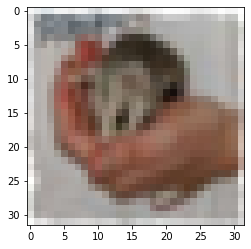

In [84]:
print(y_train_cifar60_69[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar60_69[0]), cmap=plt.cm.binary)

In [85]:
x_train_cifar60_69.shape

(5000, 32, 32, 3)

In [86]:
y_train_cifar60_69.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [87]:
x_train_cifar60_69 = x_train_cifar60_69.astype('float32')
x_train_cifar60_69 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 60-69'
epochs = 2
k_fold(x_train_cifar60_69, y_train_cifar60_69, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2077 - accuracy: 0.1867
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8785 - accuracy: 0.3511
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.2038 - accuracy: 0.2219
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.8496 - accuracy: 0.3483
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 2.0816 - accuracy: 0.2597
Epoch 2/2
13/13 [==============================] - 0s 6ms/step - loss: 1.6874 - accuracy: 0.4078

num_of_students: 3
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.2183 - accuracy: 0.1994
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.9147 - accuracy: 0.3315
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.2331 - accuracy: 0.2090
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8114 - accuracy: 0.3730
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 2.0497 - accuracy: 0.3053
Epoch 2/2
13/13 [==============================] - 0s 6ms/step - loss: 1.7121 - accuracy: 0.4326

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2280 - accuracy: 0.1733
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9562 - accuracy: 0.2867
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2871 - accuracy: 0.1460
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 2.0730 - accuracy: 0.2702
Epoch 1/2
12/12 [==============================] - 1s 6ms/step - loss: 2.1240 - accuracy: 0.2761
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.6976 - accuracy: 0.4197

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.3012 - accuracy: 0.1584
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 2.0438 - accuracy: 0.2702
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.0914 - accuracy: 0.2536
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.7145 - accuracy: 0.4207
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0680 - accuracy: 0.3115
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.5362 - accuracy: 0.4712

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.1321 - accuracy: 0.2133
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.8449 - accuracy: 0.3400
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2841 - accuracy: 0.2037
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9909 - accuracy: 0.4012
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2142 - accuracy: 0.2645
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8307 - accuracy: 0.3983

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2874 - accuracy: 0.1821
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 2.0278 - accuracy: 0.3210
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1722 - accuracy: 0.2190
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7840 - accuracy: 0.3804
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1470 - accuracy: 0.2744
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7424 - accuracy: 0.3931

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.1822 - accuracy: 0.1844
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.7418 - accuracy: 0.3578
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2851 - accuracy: 0.1827
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.1183 - accuracy: 0.2879
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1260 - accuracy: 0.2287
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7293 - accuracy: 0.3720

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 6ms/step - loss: 2.2505 - accuracy: 0.2012
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9715 - accuracy: 0.3406
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1318 - accuracy: 0.2493
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7621 - accuracy: 0.3922
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0031 - accuracy: 0.2984
Epoch 2/2
12/12 [==============================] - 0s 8ms/step - loss: 1.6175 - accuracy: 0.4293

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2621 - accuracy: 0.1822
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8995 - accuracy: 0.3178
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2023 - accuracy: 0.2147
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8522 - accuracy: 0.3558
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1064 - accuracy: 0.2334
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7780 - accuracy: 0.3372

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1429 - accuracy: 0.2454
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7341 - accuracy: 0.3804
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.2066 - accuracy: 0.2394
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8508 - accuracy: 0.3324
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0262 - accuracy: 0.2842
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.5454 - accuracy: 0.4370

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2817 - accuracy: 0.1467
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9278 - accuracy: 0.3156
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1699 - accuracy: 0.2066
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7257 - accuracy: 0.3922
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1720 - accuracy: 0.2500
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7137 - accuracy: 0.3548

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1579 - accuracy: 0.2275
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7433 - accuracy: 0.3982
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0099 - accuracy: 0.3224
Epoch 2/2
12/12 [==============================] - 0s 8ms/step - loss: 1.6108 - accuracy: 0.4372
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9200 - accuracy: 0.3656
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.4679 - accuracy: 0.4939

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2201 - accuracy: 0.1956
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8556 - accuracy: 0.3067
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1550 - accuracy: 0.2183
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8114 - accuracy: 0.3510
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0823 - accuracy: 0.2528
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6526 - accuracy: 0.4639

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1234 - accuracy: 0.2153
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7392 - accuracy: 0.3894
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.2049 - accuracy: 0.2235
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8243 - accuracy: 0.3352
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.8892 - accuracy: 0.3290
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.5389 - accuracy: 0.4422

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2373 - accuracy: 0.1667
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9096 - accuracy: 0.3289
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1710 - accuracy: 0.2412
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7489 - accuracy: 0.4118
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1946 - accuracy: 0.2676
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7501 - accuracy: 0.3514

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.0816 - accuracy: 0.2618
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7606 - accuracy: 0.3647
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0677 - accuracy: 0.2861
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6790 - accuracy: 0.4016
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9487 - accuracy: 0.3455
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.5269 - accuracy: 0.4234

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.1353 - accuracy: 0.2244
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.7507 - accuracy: 0.3244
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2123 - accuracy: 0.1865
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8792 - accuracy: 0.3242
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2327 - accuracy: 0.2174
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8764 - accuracy: 0.3391

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2791 - accuracy: 0.1346
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9596 - accuracy: 0.2875
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2463 - accuracy: 0.1789
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8941 - accuracy: 0.2903
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0329 - accuracy: 0.2514
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6353 - accuracy: 0.4153

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.1766 - accuracy: 0.2156
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.7645 - accuracy: 0.3356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2515 - accuracy: 0.1646
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9191 - accuracy: 0.3292
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1344 - accuracy: 0.2458
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7357 - accuracy: 0.3814

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2338 - accuracy: 0.1739
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0191 - accuracy: 0.3292
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1455 - accuracy: 0.2265
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7907 - accuracy: 0.3441
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0720 - accuracy: 0.2663
Epoch 2/2
12/12 [==============================] - 0s 8ms/step - loss: 1.6915 - accuracy: 0.3533

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 70-79

### reshape dataset

In [88]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=70] = True
indexes_train_2[y_train_cifar100<=79] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar70_79 = x_train_cifar100[indexes_train==True]
y_train_cifar70_79 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [89]:
y_train_cifar70_79 = y_train_cifar70_79 - 70

1


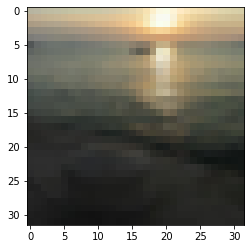

In [90]:
print(y_train_cifar70_79[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar70_79[0]), cmap=plt.cm.binary)

In [91]:
x_train_cifar70_79.shape

(5000, 32, 32, 3)

In [92]:
y_train_cifar70_79.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [93]:
x_train_cifar70_79 = x_train_cifar70_79.astype('float32')
x_train_cifar70_79 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 70-79'
epochs = 2
k_fold(x_train_cifar70_79, y_train_cifar70_79, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2229 - accuracy: 0.1822
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.9028 - accuracy: 0.3333
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2350 - accuracy: 0.2219
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0106 - accuracy: 0.3166
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2178 - accuracy: 0.2102
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8876 - accuracy: 0.3409

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2086 - accuracy: 0.2456
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8703 - accuracy: 0.3550
Epoch 1/2
12/12 [==============================] - 1s 6ms/step - loss: 2.2237 - accuracy: 0.2465
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.9410 - accuracy: 0.3456
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0721 - accuracy: 0.2670
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6542 - accuracy: 0.4162

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2356 - accuracy: 0.1867
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.8528 - accuracy: 0.3200
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2075 - accuracy: 0.1944
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 1.8621 - accuracy: 0.3511
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1789 - accuracy: 0.2370
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8419 - accuracy: 0.3353

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2439 - accuracy: 0.2226
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.8947 - accuracy: 0.3166
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2038 - accuracy: 0.2149
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8370 - accuracy: 0.4060
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1332 - accuracy: 0.2877
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.6731 - accuracy: 0.4245

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2198 - accuracy: 0.1533
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.8812 - accuracy: 0.3333
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2210 - accuracy: 0.2013
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.8576 - accuracy: 0.4026
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2583 - accuracy: 0.1860
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9221 - accuracy: 0.3415

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3521 - accuracy: 0.1438
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1240 - accuracy: 0.2588
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.1947 - accuracy: 0.2278
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9114 - accuracy: 0.3608
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1270 - accuracy: 0.2657
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7490 - accuracy: 0.3821

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.1570 - accuracy: 0.2111
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8018 - accuracy: 0.3289
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2627 - accuracy: 0.2099
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9766 - accuracy: 0.2932
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2066 - accuracy: 0.2174
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8653 - accuracy: 0.3420

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2574 - accuracy: 0.2377
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9344 - accuracy: 0.3210
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1659 - accuracy: 0.2391
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7923 - accuracy: 0.3732
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0419 - accuracy: 0.2941
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6320 - accuracy: 0.4091

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2400 - accuracy: 0.1733
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8727 - accuracy: 0.3156
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2272 - accuracy: 0.2691
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8775 - accuracy: 0.3058
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1273 - accuracy: 0.2735
Epoch 2/2
12/12 [==============================] - 0s 8ms/step - loss: 1.7186 - accuracy: 0.3867

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1727 - accuracy: 0.2691
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8317 - accuracy: 0.3425
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0923 - accuracy: 0.3277
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6806 - accuracy: 0.3838
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9483 - accuracy: 0.3953
Epoch 2/2
13/13 [==============================] - 0s 8ms/step - loss: 1.5109 - accuracy: 0.4651

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2170 - accuracy: 0.2000
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8952 - accuracy: 0.3178
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.0365 - accuracy: 0.3181
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.6788 - accuracy: 0.4011
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9977 - accuracy: 0.3131
Epoch 2/2
13/13 [==============================] - 0s 6ms/step - loss: 1.5884 - accuracy: 0.4268

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1910 - accuracy: 0.2751
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7971 - accuracy: 0.3524
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9677 - accuracy: 0.3675
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.5116 - accuracy: 0.4500
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 1.6701 - accuracy: 0.4763
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.3149 - accuracy: 0.5496

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 8ms/step - loss: 2.2128 - accuracy: 0.2356
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8094 - accuracy: 0.3600
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1931 - accuracy: 0.2508
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8323 - accuracy: 0.3263
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0189 - accuracy: 0.3597
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6231 - accuracy: 0.4441

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2512 - accuracy: 0.2326
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9370 - accuracy: 0.3353
Epoch 1/2
11/11 [==============================] - 1s 9ms/step - loss: 2.0987 - accuracy: 0.2968
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.6614 - accuracy: 0.3746
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 1.9220 - accuracy: 0.3782
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.4925 - accuracy: 0.4645

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2217 - accuracy: 0.1867
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9020 - accuracy: 0.2844
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.0986 - accuracy: 0.3029
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7243 - accuracy: 0.3882
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 2.0064 - accuracy: 0.3514
Epoch 2/2
13/13 [==============================] - 0s 7ms/step - loss: 1.6210 - accuracy: 0.4367

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1572 - accuracy: 0.2676
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7985 - accuracy: 0.3588
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 1.9945 - accuracy: 0.3448
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.5237 - accuracy: 0.4828
Epoch 1/2
14/14 [==============================] - 1s 7ms/step - loss: 1.8227 - accuracy: 0.4238
Epoch 2/2
14/14 [==============================] - 0s 6ms/step - loss: 1.4109 - accuracy: 0.5071

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.1913 - accuracy: 0.1933
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9130 - accuracy: 0.3200
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2512 - accuracy: 0.2051
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9869 - accuracy: 0.2853
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1301 - accuracy: 0.2997
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.6573 - accuracy: 0.4036

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2555 - accuracy: 0.1538
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0304 - accuracy: 0.2917
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1222 - accuracy: 0.2423
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7713 - accuracy: 0.3466
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0771 - accuracy: 0.3155
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6907 - accuracy: 0.4225

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2115 - accuracy: 0.2156
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.8587 - accuracy: 0.3378
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1069 - accuracy: 0.2848
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.7467 - accuracy: 0.3636
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0570 - accuracy: 0.3146
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6338 - accuracy: 0.4270

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2190 - accuracy: 0.2333
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 1.8080 - accuracy: 0.3667
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0280 - accuracy: 0.3125
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6000 - accuracy: 0.4348
Epoch 1/2
13/13 [==============================] - 1s 8ms/step - loss: 1.8606 - accuracy: 0.4082
Epoch 2/2
13/13 [==============================] - 0s 8ms/step - loss: 1.4245 - accuracy: 0.5121

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 80-89

### reshape dataset

In [94]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=80] = True
indexes_train_2[y_train_cifar100<=89] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar80_89 = x_train_cifar100[indexes_train==True]
y_train_cifar80_89 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [95]:
y_train_cifar80_89 = y_train_cifar80_89 - 80

6


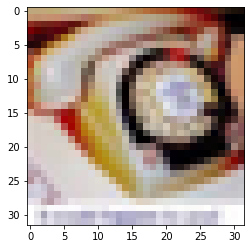

In [96]:
print(y_train_cifar80_89[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar80_89[0]), cmap=plt.cm.binary)

In [97]:
x_train_cifar80_89.shape

(5000, 32, 32, 3)

In [98]:
y_train_cifar80_89.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [99]:
x_train_cifar80_89 = x_train_cifar80_89.astype('float32')
x_train_cifar80_89 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 80-89'
epochs = 2
k_fold(x_train_cifar80_89, y_train_cifar80_89, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2834 - accuracy: 0.1489
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0584 - accuracy: 0.2089
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2050 - accuracy: 0.1707
Epoch 2/2
11/11 [==============================] - 0s 6ms/step - loss: 1.9276 - accuracy: 0.2874
Epoch 1/2
11/11 [==============================] - 1s 6ms/step - loss: 2.2075 - accuracy: 0.2328
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8884 - accuracy: 0.2902

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1667 - accuracy: 0.2365
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8437 - accuracy: 0.3174
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1647 - accuracy: 0.2479
Epoch 2/2
12/12 [==============================] - 0s 6ms/step - loss: 1.8013 - accuracy: 0.3482
Epoch 1/2
12/12 [==============================] - 1s 6ms/step - loss: 1.9836 - accuracy: 0.3107
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6203 - accuracy: 0.4047

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2696 - accuracy: 0.1533
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0544 - accuracy: 0.2356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2794 - accuracy: 0.1400
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1221 - accuracy: 0.2300
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2738 - accuracy: 0.1595
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0219 - accuracy: 0.2425

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2712 - accuracy: 0.1700
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0759 - accuracy: 0.2333
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2553 - accuracy: 0.1800
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0090 - accuracy: 0.2533
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2682 - accuracy: 0.1362
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1214 - accuracy: 0.2558

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2934 - accuracy: 0.1244
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0613 - accuracy: 0.2333
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2968 - accuracy: 0.1000
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1331 - accuracy: 0.2258
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2355 - accuracy: 0.1968
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9364 - accuracy: 0.3097

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3080 - accuracy: 0.1097
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1556 - accuracy: 0.1968
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.1971 - accuracy: 0.1968
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.8453 - accuracy: 0.3323
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2186 - accuracy: 0.1529
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8690 - accuracy: 0.3500

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3033 - accuracy: 0.1556
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1311 - accuracy: 0.2333
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2669 - accuracy: 0.1329
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0559 - accuracy: 0.2791
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2616 - accuracy: 0.1213
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0037 - accuracy: 0.2426

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2557 - accuracy: 0.1661
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0720 - accuracy: 0.2193
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2777 - accuracy: 0.1353
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1278 - accuracy: 0.2211
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2092 - accuracy: 0.2138
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 1.9345 - accuracy: 0.3092

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2817 - accuracy: 0.1622
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.0767 - accuracy: 0.2289
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3247 - accuracy: 0.1291
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1127 - accuracy: 0.2384
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3236 - accuracy: 0.1083
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2271 - accuracy: 0.1561

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2954 - accuracy: 0.1358
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1277 - accuracy: 0.2185
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2921 - accuracy: 0.1538
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0869 - accuracy: 0.2212
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2474 - accuracy: 0.1752
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9462 - accuracy: 0.2568

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3178 - accuracy: 0.1378
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.2266 - accuracy: 0.2333
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2996 - accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0844 - accuracy: 0.3000
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3539 - accuracy: 0.1316
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1737 - accuracy: 0.1809

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3172 - accuracy: 0.0933
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2057 - accuracy: 0.2200
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2920 - accuracy: 0.1667
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0431 - accuracy: 0.2967
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3105 - accuracy: 0.1180
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1620 - accuracy: 0.2262

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3076 - accuracy: 0.1667
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1014 - accuracy: 0.2467
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3490 - accuracy: 0.0930
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2173 - accuracy: 0.1595
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3197 - accuracy: 0.1395
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1169 - accuracy: 0.2791

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3266 - accuracy: 0.1130
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1897 - accuracy: 0.1927
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3645 - accuracy: 0.0997
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2220 - accuracy: 0.2359
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3289 - accuracy: 0.1296
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1887 - accuracy: 0.1960

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2890 - accuracy: 0.1622
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.0913 - accuracy: 0.2556
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2801 - accuracy: 0.1589
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0614 - accuracy: 0.2399
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.1008 - accuracy: 0.2618
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7882 - accuracy: 0.3510

num_of_students: 3
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2833 - accuracy: 0.1807
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.1137 - accuracy: 0.2087
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2763 - accuracy: 0.2093
Epoch 2/2
11/11 [==============================] - 0s 8ms/step - loss: 2.0262 - accuracy: 0.2587
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 1.9845 - accuracy: 0.2759
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.6832 - accuracy: 0.3767

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2963 - accuracy: 0.1511
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1287 - accuracy: 0.2711
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2650 - accuracy: 0.1574
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0137 - accuracy: 0.2557
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2846 - accuracy: 0.1415
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 1.9920 - accuracy: 0.2990

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3355 - accuracy: 0.1311
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1230 - accuracy: 0.2033
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2666 - accuracy: 0.1646
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9831 - accuracy: 0.2468
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1124 - accuracy: 0.2556
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8382 - accuracy: 0.3230

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3118 - accuracy: 0.1422
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1676 - accuracy: 0.2089
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3713 - accuracy: 0.1049
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1094 - accuracy: 0.2557
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2767 - accuracy: 0.1851
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0540 - accuracy: 0.2403

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3267 - accuracy: 0.1213
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1170 - accuracy: 0.2098
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2546 - accuracy: 0.1810
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9966 - accuracy: 0.2791
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0981 - accuracy: 0.2596
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7589 - accuracy: 0.3497

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

## CIFAR100 classes: 90-99



### reshape dataset

In [100]:
indexes_train_1 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_cifar100.shape[0], dtype=bool)
indexes_train_1[y_train_cifar100>=90] = True
indexes_train_2[y_train_cifar100<=99] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_cifar90_99 = x_train_cifar100[indexes_train==True]
y_train_cifar90_99 = y_train_cifar100[indexes_train==True]

rescale labels to start from 0

In [101]:
y_train_cifar90_99 = y_train_cifar90_99 - 90

0


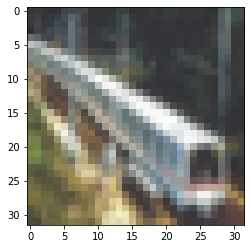

In [102]:
print(y_train_cifar90_99[0])
plt.figure()
plt.imshow(np.squeeze(x_train_cifar90_99[0]), cmap=plt.cm.binary)

In [103]:
x_train_cifar90_99.shape

(5000, 32, 32, 3)

In [104]:
y_train_cifar90_99.shape

(5000,)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [105]:
x_train_cifar90_99 = x_train_cifar90_99.astype('float32')
x_train_cifar90_99 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'CIFAR100 90-99'
epochs = 2
k_fold(x_train_cifar90_99, y_train_cifar90_99, dsName=dsName, epochs=epochs)

outer fold = 1
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2385 - accuracy: 0.1844
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9670 - accuracy: 0.2867
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3003 - accuracy: 0.1150
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.1042 - accuracy: 0.2812
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2973 - accuracy: 0.1597
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0599 - accuracy: 0.2556

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3297 - accuracy: 0.1278
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.2188 - accuracy: 0.2492
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3360 - accuracy: 0.1182
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.2024 - accuracy: 0.2460
Epoch 1/2
10/10 [==============================] - 1s 6ms/step - loss: 2.3083 - accuracy: 0.1597
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1354 - accuracy: 0.2109

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 2
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.2581 - accuracy: 0.1733
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9973 - accuracy: 0.3533
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3218 - accuracy: 0.1470
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.1301 - accuracy: 0.2684
Epoch 1/2
10/10 [==============================] - 1s 9ms/step - loss: 2.2856 - accuracy: 0.1310
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0948 - accuracy: 0.2780

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3271 - accuracy: 0.1022
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0754 - accuracy: 0.2748
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2856 - accuracy: 0.1348
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0265 - accuracy: 0.2665
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2509 - accuracy: 0.1804
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0275 - accuracy: 0.3425

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 3
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3030 - accuracy: 0.1644
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1249 - accuracy: 0.2378
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2790 - accuracy: 0.1213
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0651 - accuracy: 0.2885
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.3027 - accuracy: 0.1311
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1457 - accuracy: 0.2885

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2968 - accuracy: 0.1180
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0740 - accuracy: 0.2754
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2925 - accuracy: 0.1282
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0819 - accuracy: 0.3077
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2573 - accuracy: 0.1840
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0135 - accuracy: 0.2761

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 4
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3053 - accuracy: 0.1489
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1336 - accuracy: 0.2556
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2555 - accuracy: 0.1688
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0280 - accuracy: 0.2727
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2419 - accuracy: 0.1688
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0029 - accuracy: 0.3153

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2568 - accuracy: 0.1786
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0326 - accuracy: 0.2727
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2540 - accuracy: 0.1783
Epoch 2/2
10/10 [==============================] - 0s 6ms/step - loss: 2.0107 - accuracy: 0.2452
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2848 - accuracy: 0.1875
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9525 - accuracy: 0.2946

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 5
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2402 - accuracy: 0.1667
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 1.9598 - accuracy: 0.3022
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2531 - accuracy: 0.1778
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0373 - accuracy: 0.2698
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2453 - accuracy: 0.1889
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9917 - accuracy: 0.2786

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2284 - accuracy: 0.1492
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9956 - accuracy: 0.2730
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1744 - accuracy: 0.2377
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 2.0479 - accuracy: 0.2716
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1688 - accuracy: 0.2418
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8143 - accuracy: 0.3522

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 6
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3138 - accuracy: 0.1267
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 2.1486 - accuracy: 0.2578
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2054 - accuracy: 0.2190
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9082 - accuracy: 0.3464
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.2055 - accuracy: 0.2056
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9682 - accuracy: 0.2741

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2972 - accuracy: 0.1471
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0769 - accuracy: 0.2680
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1454 - accuracy: 0.2422
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9213 - accuracy: 0.3191
Epoch 1/2
13/13 [==============================] - 1s 7ms/step - loss: 2.0035 - accuracy: 0.3317
Epoch 2/2
13/13 [==============================] - 0s 8ms/step - loss: 1.7051 - accuracy: 0.4070

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 7
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2363 - accuracy: 0.1356
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9963 - accuracy: 0.3222
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.1912 - accuracy: 0.2141
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 1.9363 - accuracy: 0.2907
Epoch 1/2
11/11 [==============================] - 1s 7ms/step - loss: 2.1456 - accuracy: 0.2523
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9095 - accuracy: 0.3100

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2506 - accuracy: 0.1757
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0219 - accuracy: 0.2907
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2035 - accuracy: 0.1844
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0197 - accuracy: 0.2906
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2168 - accuracy: 0.2156
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 1.9329 - accuracy: 0.3406

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 8
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.2622 - accuracy: 0.1844
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 1.9824 - accuracy: 0.3200
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3068 - accuracy: 0.1442
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.1262 - accuracy: 0.2147
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2527 - accuracy: 0.2045
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 1.9967 - accuracy: 0.3067

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2719 - accuracy: 0.1506
Epoch 2/2
10/10 [==============================] - 0s 9ms/step - loss: 2.0868 - accuracy: 0.2212
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1924 - accuracy: 0.2568
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8847 - accuracy: 0.3172
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.0901 - accuracy: 0.2762
Epoch 2/2
12/12 [==============================] - 0s 8ms/step - loss: 1.7826 - accuracy: 0.3785

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 9
Epoch 1/2
15/15 [==============================] - 1s 7ms/step - loss: 2.3219 - accuracy: 0.1511
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1176 - accuracy: 0.2356
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.3090 - accuracy: 0.1553
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0646 - accuracy: 0.2265
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2970 - accuracy: 0.1783
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0696 - accuracy: 0.2866

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2792 - accuracy: 0.1553
Epoch 2/2
10/10 [==============================] - 0s 7ms/step - loss: 2.0663 - accuracy: 0.2298
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.2458 - accuracy: 0.1620
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.9889 - accuracy: 0.2648
Epoch 1/2
12/12 [==============================] - 1s 7ms/step - loss: 2.1322 - accuracy: 0.2438
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.8379 - accuracy: 0.3850

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

outer fold = 10
Epoch 1/2
15/15 [==============================] - 1s 6ms/step - loss: 2.3218 - accuracy: 0.1267
Epoch 2/2
15/15 [==============================] - 0s 7ms/step - loss: 2.1209 - accuracy: 0.2733
unl_factor: 0.1
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/2
10/10 [==============================] - 1s 7ms/step - loss: 2.2296 - accuracy: 0.1672
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0260 - accuracy: 0.2862
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.2578 - accuracy: 0.1703
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 2.0213 - accuracy: 0.3028

num_of_students: 3
Epoch 1/2
10/10 [==============================] - 1s 8ms/step - loss: 2.1910 - accuracy: 0.1865
Epoch 2/2
10/10 [==============================] - 0s 8ms/step - loss: 1.9519 - accuracy: 0.3183
Epoch 1/2
11/11 [==============================] - 1s 8ms/step - loss: 2.1891 - accuracy: 0.2222
Epoch 2/2
11/11 [==============================] - 0s 7ms/step - loss: 1.8951 - accuracy: 0.3305
Epoch 1/2
12/12 [==============================] - 1s 8ms/step - loss: 2.0919 - accuracy: 0.2739
Epoch 2/2
12/12 [==============================] - 0s 7ms/step - loss: 1.7706 - accuracy: 0.3750

threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in

# A-Z Handwritten Alphabets

## Import the A-Z Handwritten Alphabets dataset

In [107]:
data_A_Z = pd.read_csv('/content/drive/MyDrive/University/סמסטר ו/למידה חישובית יישומית/פרוייקט/A_Z Handwritten Data/A_Z Handwritten Data.csv')
data_A_Z

0  0.1  0.2  0.3  0.4  0.5  ...  0.643  0.644  0.645  0.646  0.647  0.648
0        0    0    0    0    0    0  ...      0      0      0      0      0      0
1        0    0    0    0    0    0  ...      0      0      0      0      0      0
2        0    0    0    0    0    0  ...      0      0      0      0      0      0
3        0    0    0    0    0    0  ...      0      0      0      0      0      0
4        0    0    0    0    0    0  ...      0      0      0      0      0      0
...     ..  ...  ...  ...  ...  ...  ...    ...    ...    ...    ...    ...    ...
372445  25    0    0    0    0    0  ...      0      0      0      0      0      0
372446  25    0    0    0    0    0  ...      0      0      0      0      0      0
372447  25    0    0    0    0    0  ...      0      0      0      0      0      0
372448  25    0    0    0    0    0  ...      0      0      0      0      0      0
372449  25    0    0    0    0    0  ...      0      0      0      0      0      0

[372450 rows x 785 columns]

suffle the data so when we split the data to different fold, it will be shuffled

In [108]:
n=len(data_A_Z)
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

x_data_A_Z = data_A_Z.iloc[:, 1:]
y_data_A_Z = data_A_Z.iloc[:, 0]
x_data_A_Z = x_data_A_Z.values.reshape(-1,28,28)

x_train_A_Z = x_data_A_Z
y_train_A_Z = y_data_A_Z.to_numpy()

x_train_A_Z = x_train_A_Z[N]
y_train_A_Z = y_train_A_Z[N]

In [109]:
x_train_A_Z = np.stack(x_train_A_Z, axis=0)
x_train_A_Z = np.expand_dims(x_train_A_Z,axis=3)
x_train_A_Z.shape

(372450, 28, 28, 1)

In [110]:
y_train_A_Z.shape

(372450,)

17


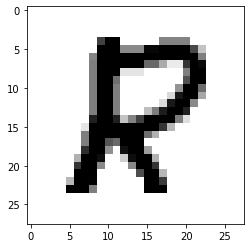

In [111]:
print(y_train_A_Z[0])
plt.imshow(np.squeeze(x_train_A_Z[0]), cmap=plt.cm.binary)
plt.show()

## A-Z Handwritten Alphabets classes: 0-4

### reshape dataset

In [112]:
indexes_train = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train[y_train_A_Z<=4] = True
x_train_A_Z_0_4 = x_train_A_Z[indexes_train==True]
y_train_A_Z_0_4 = y_train_A_Z[indexes_train==True]

0


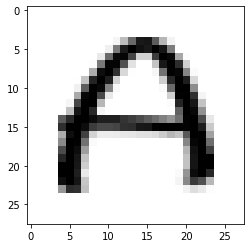

In [113]:
print(y_train_A_Z_0_4[0])
plt.figure()
plt.imshow(np.squeeze(x_train_A_Z_0_4[0]), cmap=plt.cm.binary)

In [114]:
x_train_A_Z_0_4.shape

(67520, 28, 28, 1)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [115]:
x_train_A_Z_0_4 = x_train_A_Z_0_4.astype('float32')
x_train_A_Z_0_4 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'A-Z Handwritten 0-4'
epochs = 5
k_fold(x_train_A_Z_0_4, y_train_A_Z_0_4, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
190/190 [==============================] - 2s 6ms/step - loss: 0.2618 - accuracy: 0.9082
Epoch 2/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0661 - accuracy: 0.9801
Epoch 3/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0433 - accuracy: 0.9860
Epoch 4/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0259 - accuracy: 0.9911
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0193 - accuracy: 0.9929
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9427
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0449 - accuracy: 0.9865
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9910
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0215 - accuracy: 0.9937
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0194 - accuracy: 0.9942
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1067 - accuracy: 0.9632
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0286 - accuracy: 0.9909
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0199 - accuracy: 0.9939
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0158 - accuracy: 0.9946
Epoch 5/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0129 - accuracy: 0.9957

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2587 - accuracy: 0.9110
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0509 - accuracy: 0.9832
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0312 - accuracy: 0.9913
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0248 - accuracy: 0.9918
Epoch 5/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0132 - accuracy: 0.9961
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 2s 5ms/step - loss: 0.1456 - accuracy: 0.9489
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9883
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0278 - accuracy: 0.9901
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0185 - accuracy: 0.9945
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0135 - accuracy: 0.9960
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1035 - accuracy: 0.9654
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0300 - accuracy: 0.9902
Epoch 3/5
631/631 [==============================] - 4s 6ms/step - loss: 0.0178 - accuracy: 0.9940
Epoch 4/5
631/631 [==============================] - 4s 6ms/step - loss: 0.0140 - accuracy: 0.9952
Epoch 5/5
631/631 [==============================] - 4s 6ms/step - loss: 0.0129 - accuracy: 0.9955

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2490 - accuracy: 0.9166
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0605 - accuracy: 0.9803
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0315 - accuracy: 0.9914
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0227 - accuracy: 0.9926
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0141 - accuracy: 0.9962
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 2s 5ms/step - loss: 0.1605 - accuracy: 0.9423
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0413 - accuracy: 0.9869
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9910
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0199 - accuracy: 0.9936
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0182 - accuracy: 0.9936
Epoch 1/5
630/630 [==============================] - 4s 5ms/step - loss: 0.1087 - accuracy: 0.9623
Epoch 2/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0301 - accuracy: 0.9900
Epoch 3/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0221 - accuracy: 0.9926
Epoch 4/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0182 - accuracy: 0.9939
Epoch 5/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0156 - accuracy: 0.9946

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2700 - accuracy: 0.9044
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0522 - accuracy: 0.9829
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0301 - accuracy: 0.9911
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0178 - accuracy: 0.9949
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0104 - accuracy: 0.9977
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 3s 5ms/step - loss: 0.1624 - accuracy: 0.9415
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0408 - accuracy: 0.9866
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9902
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0237 - accuracy: 0.9929
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0164 - accuracy: 0.9946
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1224 - accuracy: 0.9574
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0313 - accuracy: 0.9893
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0235 - accuracy: 0.9923
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0178 - accuracy: 0.9941
Epoch 5/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0157 - accuracy: 0.9947

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2447 - accuracy: 0.9162
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0540 - accuracy: 0.9832
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0324 - accuracy: 0.9900
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0259 - accuracy: 0.9918
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0153 - accuracy: 0.9957
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 2s 5ms/step - loss: 0.1593 - accuracy: 0.9448
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0377 - accuracy: 0.9878
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0258 - accuracy: 0.9920
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0166 - accuracy: 0.9945
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0166 - accuracy: 0.9946
Epoch 1/5
630/630 [==============================] - 4s 5ms/step - loss: 0.1206 - accuracy: 0.9589
Epoch 2/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0312 - accuracy: 0.9896
Epoch 3/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0214 - accuracy: 0.9928
Epoch 4/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0156 - accuracy: 0.9939
Epoch 5/5
630/630 [==============================] - 3s 5ms/step - loss: 0.0135 - accuracy: 0.9956

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2457 - accuracy: 0.9154
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0618 - accuracy: 0.9799
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0300 - accuracy: 0.9903
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0168 - accuracy: 0.9956
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0122 - accuracy: 0.9962
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 2s 5ms/step - loss: 0.1545 - accuracy: 0.9472
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0391 - accuracy: 0.9872
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0229 - accuracy: 0.9927
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0170 - accuracy: 0.9941
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0166 - accuracy: 0.9946
Epoch 1/5
632/632 [==============================] - 4s 5ms/step - loss: 0.1169 - accuracy: 0.9581
Epoch 2/5
632/632 [==============================] - 3s 5ms/step - loss: 0.0274 - accuracy: 0.9904
Epoch 3/5
632/632 [==============================] - 3s 5ms/step - loss: 0.0170 - accuracy: 0.9942
Epoch 4/5
632/632 [==============================] - 3s 5ms/step - loss: 0.0134 - accuracy: 0.9955
Epoch 5/5
632/632 [==============================] - 3s 5ms/step - loss: 0.0118 - accuracy: 0.9956

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2522 - accuracy: 0.9124
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0581 - accuracy: 0.9814
Epoch 3/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0332 - accuracy: 0.9890
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0170 - accuracy: 0.9959
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0112 - accuracy: 0.9969
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
378/378 [==============================] - 2s 5ms/step - loss: 0.1524 - accuracy: 0.9494
Epoch 2/5
378/378 [==============================] - 2s 5ms/step - loss: 0.0438 - accuracy: 0.9863
Epoch 3/5
378/378 [==============================] - 2s 5ms/step - loss: 0.0305 - accuracy: 0.9901
Epoch 4/5
378/378 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.9925
Epoch 5/5
378/378 [==============================] - 2s 5ms/step - loss: 0.0164 - accuracy: 0.9946
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1034 - accuracy: 0.9651
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0313 - accuracy: 0.9897
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0237 - accuracy: 0.9916
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0183 - accuracy: 0.9940
Epoch 5/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0141 - accuracy: 0.9950

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2345 - accuracy: 0.9197
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0474 - accuracy: 0.9844
Epoch 3/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0283 - accuracy: 0.9914
Epoch 4/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0191 - accuracy: 0.9941
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0156 - accuracy: 0.9964
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 3s 5ms/step - loss: 0.1620 - accuracy: 0.9451
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0413 - accuracy: 0.9860
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0235 - accuracy: 0.9925
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0161 - accuracy: 0.9952
Epoch 5/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0161 - accuracy: 0.9943
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1085 - accuracy: 0.9631
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0276 - accuracy: 0.9912
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0186 - accuracy: 0.9940
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0145 - accuracy: 0.9949
Epoch 5/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0110 - accuracy: 0.9963

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
190/190 [==============================] - 1s 5ms/step - loss: 0.2520 - accuracy: 0.9110
Epoch 2/5
190/190 [==============================] - 1s 5ms/step - loss: 0.0540 - accuracy: 0.9819
Epoch 3/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.9888
Epoch 4/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0198 - accuracy: 0.9941
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0139 - accuracy: 0.9952
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 3s 5ms/step - loss: 0.1753 - accuracy: 0.9385
Epoch 2/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0604 - accuracy: 0.9796
Epoch 3/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0360 - accuracy: 0.9877
Epoch 4/5
379/379 [==============================] - 2s 5ms/step - loss: 0.0268 - accuracy: 0.9902
Epoch 5/5
379/379 [==============================] - 2s 6ms/step - loss: 0.0276 - accuracy: 0.9900
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1156 - accuracy: 0.9587
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0386 - accuracy: 0.9869
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0306 - accuracy: 0.9894
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0223 - accuracy: 0.9925
Epoch 5/5
631/631 [==============================] - 4s 6ms/step - loss: 0.0210 - accuracy: 0.9930

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
190/190 [==============================] - 2s 5ms/step - loss: 0.2559 - accuracy: 0.9095
Epoch 2/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0577 - accuracy: 0.9812
Epoch 3/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0284 - accuracy: 0.9916
Epoch 4/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0206 - accuracy: 0.9941
Epoch 5/5
190/190 [==============================] - 1s 6ms/step - loss: 0.0152 - accuracy: 0.9952
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
379/379 [==============================] - 3s 6ms/step - loss: 0.1583 - accuracy: 0.9467
Epoch 2/5
379/379 [==============================] - 2s 6ms/step - loss: 0.0382 - accuracy: 0.9887
Epoch 3/5
379/379 [==============================] - 2s 6ms/step - loss: 0.0258 - accuracy: 0.9907
Epoch 4/5
379/379 [==============================] - 2s 6ms/step - loss: 0.0157 - accuracy: 0.9952
Epoch 5/5
379/379 [==============================] - 2s 6ms/step - loss: 0.0147 - accuracy: 0.9950
Epoch 1/5
631/631 [==============================] - 4s 5ms/step - loss: 0.1150 - accuracy: 0.9610
Epoch 2/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0320 - accuracy: 0.9890
Epoch 3/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0229 - accuracy: 0.9923
Epoch 4/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0182 - accuracy: 0.9939
Epoch 5/5
631/631 [==============================] - 3s 5ms/step - loss: 0.0125 - accuracy: 0.9956

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## A-Z Handwritten Alphabets classes: 5-9

### reshape dataset

In [116]:
indexes_train_1 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_1[y_train_A_Z>=5] = True
indexes_train_2[y_train_A_Z<=9] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_A_Z_5_9 = x_train_A_Z[indexes_train==True]
y_train_A_Z_5_9 = y_train_A_Z[indexes_train==True]

rescale labels to start from 0

In [117]:
y_train_A_Z_5_9 = y_train_A_Z_5_9 - 5

4


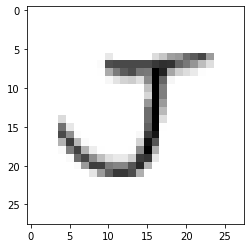

In [118]:
print(y_train_A_Z_5_9[0])
plt.figure()
plt.imshow(np.squeeze(x_train_A_Z_5_9[0]), cmap=plt.cm.binary)

In [119]:
x_train_A_Z_5_9.shape

(23756, 28, 28, 1)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [120]:
x_train_A_Z_5_9 = x_train_A_Z_5_9.astype('float32')
x_train_A_Z_5_9 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'A-Z Handwritten 5-9'
epochs = 5
k_fold(x_train_A_Z_5_9, y_train_A_Z_5_9, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
67/67 [==============================] - 1s 6ms/step - loss: 0.3751 - accuracy: 0.8807
Epoch 2/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0734 - accuracy: 0.9775
Epoch 3/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9916
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9925
Epoch 5/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9949
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1963 - accuracy: 0.9389
Epoch 2/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0336 - accuracy: 0.9906
Epoch 3/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0163 - accuracy: 0.9953
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0080 - accuracy: 0.9976
Epoch 5/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0092 - accuracy: 0.9979
Epoch 1/5
222/222 [==============================] - 2s 6ms/step - loss: 0.1226 - accuracy: 0.9630
Epoch 2/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0204 - accuracy: 0.9944
Epoch 3/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0124 - accuracy: 0.9954
Epoch 4/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0129 - accuracy: 0.9958
Epoch 5/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0068 - accuracy: 0.9979

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3825 - accuracy: 0.8821
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0687 - accuracy: 0.9813
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 0.9897
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0238 - accuracy: 0.9920
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0180 - accuracy: 0.9935
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
133/133 [==============================] - 1s 5ms/step - loss: 0.2269 - accuracy: 0.9281
Epoch 2/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0344 - accuracy: 0.9920
Epoch 3/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0213 - accuracy: 0.9941
Epoch 4/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0125 - accuracy: 0.9960
Epoch 5/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0105 - accuracy: 0.9955
Epoch 1/5
222/222 [==============================] - 2s 5ms/step - loss: 0.1373 - accuracy: 0.9585
Epoch 2/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0278 - accuracy: 0.9900
Epoch 3/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0177 - accuracy: 0.9946
Epoch 4/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9961
Epoch 5/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.9955

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.2999 - accuracy: 0.9069
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0745 - accuracy: 0.9799
Epoch 3/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0499 - accuracy: 0.9836
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0250 - accuracy: 0.9930
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0155 - accuracy: 0.9958
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 1s 6ms/step - loss: 0.2236 - accuracy: 0.9265
Epoch 2/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0426 - accuracy: 0.9876
Epoch 3/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0230 - accuracy: 0.9937
Epoch 4/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0131 - accuracy: 0.9962
Epoch 5/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0148 - accuracy: 0.9958
Epoch 1/5
222/222 [==============================] - 2s 6ms/step - loss: 0.1352 - accuracy: 0.9611
Epoch 2/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0304 - accuracy: 0.9904
Epoch 3/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0178 - accuracy: 0.9951
Epoch 4/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0122 - accuracy: 0.9958
Epoch 5/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0067 - accuracy: 0.9975

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3307 - accuracy: 0.9022
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.9794
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0494 - accuracy: 0.9869
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0286 - accuracy: 0.9902
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0291 - accuracy: 0.9906
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
133/133 [==============================] - 1s 5ms/step - loss: 0.2113 - accuracy: 0.9379
Epoch 2/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0403 - accuracy: 0.9890
Epoch 3/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0291 - accuracy: 0.9918
Epoch 4/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0175 - accuracy: 0.9951
Epoch 5/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0145 - accuracy: 0.9958
Epoch 1/5
222/222 [==============================] - 2s 5ms/step - loss: 0.1309 - accuracy: 0.9638
Epoch 2/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0281 - accuracy: 0.9922
Epoch 3/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0193 - accuracy: 0.9939
Epoch 4/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0125 - accuracy: 0.9956
Epoch 5/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0108 - accuracy: 0.9970

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3556 - accuracy: 0.8831
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0736 - accuracy: 0.9790
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0445 - accuracy: 0.9855
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0352 - accuracy: 0.9888
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 0.9958
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 2s 5ms/step - loss: 0.1888 - accuracy: 0.9453
Epoch 2/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0293 - accuracy: 0.9911
Epoch 3/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0213 - accuracy: 0.9937
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0130 - accuracy: 0.9965
Epoch 5/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0113 - accuracy: 0.9969
Epoch 1/5
222/222 [==============================] - 2s 5ms/step - loss: 0.1422 - accuracy: 0.9615
Epoch 2/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.9922
Epoch 3/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0152 - accuracy: 0.9945
Epoch 4/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0111 - accuracy: 0.9965
Epoch 5/5
222/222 [==============================] - 1s 6ms/step - loss: 0.0076 - accuracy: 0.9976

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.9013
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0676 - accuracy: 0.9813
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0461 - accuracy: 0.9869
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0296 - accuracy: 0.9902
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0117 - accuracy: 0.9958
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 1s 5ms/step - loss: 0.2067 - accuracy: 0.9328
Epoch 2/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0380 - accuracy: 0.9902
Epoch 3/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.9923
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0180 - accuracy: 0.9939
Epoch 5/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0098 - accuracy: 0.9972
Epoch 1/5
223/223 [==============================] - 2s 5ms/step - loss: 0.1519 - accuracy: 0.9499
Epoch 2/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0251 - accuracy: 0.9938
Epoch 3/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0145 - accuracy: 0.9948
Epoch 4/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0122 - accuracy: 0.9961
Epoch 5/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0072 - accuracy: 0.9975

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3698 - accuracy: 0.8756
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0688 - accuracy: 0.9794
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0468 - accuracy: 0.9850
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0283 - accuracy: 0.9897
Epoch 5/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9953
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 1s 5ms/step - loss: 0.2187 - accuracy: 0.9308
Epoch 2/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0395 - accuracy: 0.9890
Epoch 3/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0252 - accuracy: 0.9927
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.9937
Epoch 5/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0135 - accuracy: 0.9958
Epoch 1/5
222/222 [==============================] - 2s 5ms/step - loss: 0.1409 - accuracy: 0.9530
Epoch 2/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0237 - accuracy: 0.9931
Epoch 3/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0170 - accuracy: 0.9949
Epoch 4/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0135 - accuracy: 0.9948
Epoch 5/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0133 - accuracy: 0.9954

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3448 - accuracy: 0.8882
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.9752
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0447 - accuracy: 0.9846
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0237 - accuracy: 0.9935
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0112 - accuracy: 0.9972
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 1s 5ms/step - loss: 0.2246 - accuracy: 0.9299
Epoch 2/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9883
Epoch 3/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0238 - accuracy: 0.9930
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0146 - accuracy: 0.9960
Epoch 5/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0133 - accuracy: 0.9955
Epoch 1/5
223/223 [==============================] - 2s 5ms/step - loss: 0.1336 - accuracy: 0.9574
Epoch 2/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0206 - accuracy: 0.9940
Epoch 3/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0193 - accuracy: 0.9935
Epoch 4/5
223/223 [==============================] - 1s 6ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 5/5
223/223 [==============================] - 1s 6ms/step - loss: 0.0054 - accuracy: 0.9985

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
67/67 [==============================] - 1s 6ms/step - loss: 0.3553 - accuracy: 0.8920
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0793 - accuracy: 0.9790
Epoch 3/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0455 - accuracy: 0.9892
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9888
Epoch 5/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.9944
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
133/133 [==============================] - 1s 5ms/step - loss: 0.2173 - accuracy: 0.9366
Epoch 2/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0464 - accuracy: 0.9875
Epoch 3/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0299 - accuracy: 0.9901
Epoch 4/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0189 - accuracy: 0.9946
Epoch 5/5
133/133 [==============================] - 1s 5ms/step - loss: 0.0149 - accuracy: 0.9951
Epoch 1/5
222/222 [==============================] - 2s 6ms/step - loss: 0.1357 - accuracy: 0.9581
Epoch 2/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0293 - accuracy: 0.9901
Epoch 3/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0197 - accuracy: 0.9931
Epoch 4/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0132 - accuracy: 0.9952
Epoch 5/5
222/222 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9959

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
67/67 [==============================] - 1s 5ms/step - loss: 0.3521 - accuracy: 0.8887
Epoch 2/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9780
Epoch 3/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9902
Epoch 4/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9902
Epoch 5/5
67/67 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.9911
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
134/134 [==============================] - 1s 6ms/step - loss: 0.2100 - accuracy: 0.9409
Epoch 2/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0489 - accuracy: 0.9857
Epoch 3/5
134/134 [==============================] - 1s 6ms/step - loss: 0.0238 - accuracy: 0.9937
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0206 - accuracy: 0.9951
Epoch 5/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0121 - accuracy: 0.9958
Epoch 1/5
223/223 [==============================] - 2s 5ms/step - loss: 0.1309 - accuracy: 0.9613
Epoch 2/5
223/223 [==============================] - 1s 6ms/step - loss: 0.0224 - accuracy: 0.9931
Epoch 3/5
223/223 [==============================] - 1s 6ms/step - loss: 0.0115 - accuracy: 0.9969
Epoch 4/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0086 - accuracy: 0.9969
Epoch 5/5
223/223 [==============================] - 1s 5ms/step - loss: 0.0107 - accuracy: 0.9962

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## A-Z Handwritten Alphabets classes: 10-14

### reshape dataset

In [121]:
indexes_train_1 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_1[y_train_A_Z>=10] = True
indexes_train_2[y_train_A_Z<=14] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_A_Z_10_14 = x_train_A_Z[indexes_train==True]
y_train_A_Z_10_14 = y_train_A_Z[indexes_train==True]

rescale labels to start from 0

In [122]:
y_train_A_Z_10_14 = y_train_A_Z_10_14 - 10

0


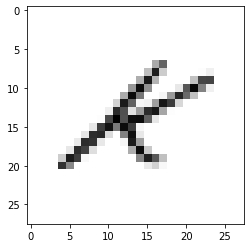

In [123]:
print(y_train_A_Z_10_14[0])
plt.figure()
plt.imshow(np.squeeze(x_train_A_Z_10_14[0]), cmap=plt.cm.binary)

In [124]:
x_train_A_Z_10_14.shape

(106360, 28, 28, 1)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [125]:
x_train_A_Z_10_14 = x_train_A_Z_10_14.astype('float32')
x_train_A_Z_10_14 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'A-Z Handwritten 10-14'
epochs = 5
k_fold(x_train_A_Z_10_14, y_train_A_Z_10_14, dsName=dsName, epochs=epochs, num_of_classes=5, teacher_factor=0.05)

outer fold = 1
Epoch 1/5
150/150 [==============================] - 32s 4ms/step - loss: 0.2176 - accuracy: 0.9231
Epoch 2/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9852
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0334 - accuracy: 0.9896
Epoch 4/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9933
Epoch 5/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9948
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1774 - accuracy: 0.9378
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0340 - accuracy: 0.9899
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9937
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9937
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0096 - accuracy: 0.9973
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1178 - accuracy: 0.9591
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.9913
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0149 - accuracy: 0.9961
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0100 - accuracy: 0.9972
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0081 - accuracy: 0.9975

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2074 - accuracy: 0.9265
Epoch 2/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0442 - accuracy: 0.9877
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.9910
Epoch 4/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0240 - accuracy: 0.9939
Epoch 5/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0136 - accuracy: 0.9967
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1699 - accuracy: 0.9422
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0317 - accuracy: 0.9887
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0145 - accuracy: 0.9950
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0100 - accuracy: 0.9975
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0132 - accuracy: 0.9956
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1267 - accuracy: 0.9561
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0234 - accuracy: 0.9933
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9963
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0102 - accuracy: 0.9966
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0089 - accuracy: 0.9968

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2054 - accuracy: 0.9252
Epoch 2/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9860
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9921
Epoch 4/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9937
Epoch 5/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9973
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
200/200 [==============================] - 1s 3ms/step - loss: 0.1685 - accuracy: 0.9380
Epoch 2/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0357 - accuracy: 0.9882
Epoch 3/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0196 - accuracy: 0.9945
Epoch 4/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9954
Epoch 5/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0100 - accuracy: 0.9975
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1327 - accuracy: 0.9519
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0230 - accuracy: 0.9939
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0168 - accuracy: 0.9950
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0110 - accuracy: 0.9970
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0082 - accuracy: 0.9978

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2203 - accuracy: 0.9244
Epoch 2/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0432 - accuracy: 0.9862
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9914
Epoch 4/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9937
Epoch 5/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9964
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 4ms/step - loss: 0.1602 - accuracy: 0.9411
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.9910
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0205 - accuracy: 0.9942
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0132 - accuracy: 0.9961
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0159 - accuracy: 0.9948
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1390 - accuracy: 0.9508
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0243 - accuracy: 0.9928
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.9955
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0113 - accuracy: 0.9963
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0088 - accuracy: 0.9971

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
150/150 [==============================] - 1s 4ms/step - loss: 0.2163 - accuracy: 0.9216
Epoch 2/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.9841
Epoch 3/5
150/150 [==============================] - 1s 6ms/step - loss: 0.0277 - accuracy: 0.9910
Epoch 4/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0199 - accuracy: 0.9944
Epoch 5/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9960
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.9418
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.9909
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0212 - accuracy: 0.9939
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0171 - accuracy: 0.9937
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0105 - accuracy: 0.9959
Epoch 1/5
298/298 [==============================] - 1s 3ms/step - loss: 0.1232 - accuracy: 0.9557
Epoch 2/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0286 - accuracy: 0.9913
Epoch 3/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0219 - accuracy: 0.9934
Epoch 4/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.9948
Epoch 5/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0110 - accuracy: 0.9969

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2005 - accuracy: 0.9310
Epoch 2/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0473 - accuracy: 0.9852
Epoch 3/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0296 - accuracy: 0.9906
Epoch 4/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0161 - accuracy: 0.9952
Epoch 5/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0120 - accuracy: 0.9960
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1806 - accuracy: 0.9380
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0312 - accuracy: 0.9893
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0179 - accuracy: 0.9943
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9969
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9976
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0989 - accuracy: 0.9652
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0205 - accuracy: 0.9930
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0118 - accuracy: 0.9960
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9968
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0068 - accuracy: 0.9979

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2140 - accuracy: 0.9271
Epoch 2/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0466 - accuracy: 0.9856
Epoch 3/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0300 - accuracy: 0.9921
Epoch 4/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0165 - accuracy: 0.9950
Epoch 5/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0126 - accuracy: 0.9962
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1815 - accuracy: 0.9378
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0328 - accuracy: 0.9884
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0215 - accuracy: 0.9934
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0119 - accuracy: 0.9972
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0114 - accuracy: 0.9961
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1234 - accuracy: 0.9561
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0261 - accuracy: 0.9917
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0170 - accuracy: 0.9939
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0131 - accuracy: 0.9958
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0109 - accuracy: 0.9962

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.2093 - accuracy: 0.9281
Epoch 2/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 0.9850
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9904
Epoch 4/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9935
Epoch 5/5
150/150 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9952
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1519 - accuracy: 0.9478
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0286 - accuracy: 0.9909
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0175 - accuracy: 0.9942
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0093 - accuracy: 0.9975
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0065 - accuracy: 0.9983
Epoch 1/5
298/298 [==============================] - 1s 3ms/step - loss: 0.1126 - accuracy: 0.9597
Epoch 2/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9922
Epoch 3/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0137 - accuracy: 0.9953
Epoch 4/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0102 - accuracy: 0.9965
Epoch 5/5
298/298 [==============================] - 1s 3ms/step - loss: 0.0055 - accuracy: 0.9978

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
150/150 [==============================] - 1s 3ms/step - loss: 0.1967 - accuracy: 0.9292
Epoch 2/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0473 - accuracy: 0.9850
Epoch 3/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0300 - accuracy: 0.9914
Epoch 4/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9944
Epoch 5/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0137 - accuracy: 0.9958
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
200/200 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.9397
Epoch 2/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0304 - accuracy: 0.9907
Epoch 3/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0238 - accuracy: 0.9922
Epoch 4/5
200/200 [==============================] - 1s 4ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 5/5
200/200 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.9972
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1143 - accuracy: 0.9587
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0235 - accuracy: 0.9929
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0128 - accuracy: 0.9961
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9974
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0082 - accuracy: 0.9970

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
150/150 [==============================] - 1s 4ms/step - loss: 0.2132 - accuracy: 0.9237
Epoch 2/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0485 - accuracy: 0.9841
Epoch 3/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0326 - accuracy: 0.9908
Epoch 4/5
150/150 [==============================] - 1s 3ms/step - loss: 0.0239 - accuracy: 0.9925
Epoch 5/5
150/150 [==============================] - 1s 4ms/step - loss: 0.0131 - accuracy: 0.9960
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
199/199 [==============================] - 1s 3ms/step - loss: 0.1736 - accuracy: 0.9359
Epoch 2/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0274 - accuracy: 0.9921
Epoch 3/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0178 - accuracy: 0.9943
Epoch 4/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9969
Epoch 5/5
199/199 [==============================] - 1s 3ms/step - loss: 0.0060 - accuracy: 0.9983
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1147 - accuracy: 0.9599
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0237 - accuracy: 0.9923
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0122 - accuracy: 0.9953
Epoch 4/5
299/299 [==============================] - 1s 4ms/step - loss: 0.0118 - accuracy: 0.9957
Epoch 5/5
299/299 [==============================] - 1s 4ms/step - loss: 0.0101 - accuracy: 0.9963

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## A-Z Handwritten Alphabets classes: 15-19

### reshape dataset

In [126]:
indexes_train_1 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_2 = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train_1[y_train_A_Z>=15] = True
indexes_train_2[y_train_A_Z<=19] = True
indexes_train = indexes_train_1*indexes_train_2
x_train_A_Z_15_19 = x_train_A_Z[indexes_train==True]
y_train_A_Z_15_19 = y_train_A_Z[indexes_train==True]

rescale labels to start from 0

In [127]:
y_train_A_Z_15_19 = y_train_A_Z_15_19 - 15

2


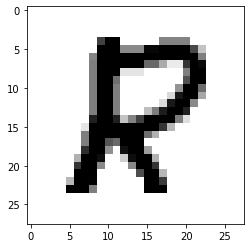

In [128]:
print(y_train_A_Z_15_19[0])
plt.figure()
plt.imshow(np.squeeze(x_train_A_Z_15_19[0]), cmap=plt.cm.binary)

In [129]:
x_train_A_Z_15_19.shape

(107633, 28, 28, 1)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [130]:
x_train_A_Z_15_19 = x_train_A_Z_15_19.astype('float32')
x_train_A_Z_15_19 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'A-Z Handwritten 15-19'
epochs = 5
k_fold(x_train_A_Z_15_19, y_train_A_Z_15_19, dsName=dsName, epochs=epochs, num_of_classes=5)

outer fold = 1
Epoch 1/5
303/303 [==============================] - 2s 6ms/step - loss: 0.1462 - accuracy: 0.9543
Epoch 2/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0310 - accuracy: 0.9904
Epoch 3/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0164 - accuracy: 0.9950
Epoch 4/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0120 - accuracy: 0.9961
Epoch 5/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0054 - accuracy: 0.9987
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 6ms/step - loss: 0.1590 - accuracy: 0.9475
Epoch 2/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0317 - accuracy: 0.9896
Epoch 3/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0214 - accuracy: 0.9924
Epoch 4/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0130 - accuracy: 0.9956
Epoch 5/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0090 - accuracy: 0.9971
Epoch 1/5
403/403 [==============================] - 3s 6ms/step - loss: 0.1212 - accuracy: 0.9573
Epoch 2/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0248 - accuracy: 0.9922
Epoch 3/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0153 - accuracy: 0.9953
Epoch 4/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.9957
Epoch 5/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0099 - accuracy: 0.9967

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1434 - accuracy: 0.9507
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0334 - accuracy: 0.9896
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0215 - accuracy: 0.9940
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0146 - accuracy: 0.9942
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0126 - accuracy: 0.9956
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 6ms/step - loss: 0.1372 - accuracy: 0.9541
Epoch 2/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0285 - accuracy: 0.9909
Epoch 3/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0188 - accuracy: 0.9941
Epoch 4/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0153 - accuracy: 0.9949
Epoch 5/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0081 - accuracy: 0.9978
Epoch 1/5
403/403 [==============================] - 3s 5ms/step - loss: 0.1235 - accuracy: 0.9595
Epoch 2/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9909
Epoch 3/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0160 - accuracy: 0.9948
Epoch 4/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 5/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0096 - accuracy: 0.9968

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1349 - accuracy: 0.9559
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0352 - accuracy: 0.9899
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0193 - accuracy: 0.9929
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0129 - accuracy: 0.9961
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0100 - accuracy: 0.9965
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1432 - accuracy: 0.9483
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0315 - accuracy: 0.9898
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0205 - accuracy: 0.9937
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0107 - accuracy: 0.9964
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0128 - accuracy: 0.9959
Epoch 1/5
403/403 [==============================] - 3s 5ms/step - loss: 0.1117 - accuracy: 0.9650
Epoch 2/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0250 - accuracy: 0.9916
Epoch 3/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0164 - accuracy: 0.9947
Epoch 4/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0121 - accuracy: 0.9961
Epoch 5/5
403/403 [==============================] - 2s 5ms/step - loss: 0.0096 - accuracy: 0.9967

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 4
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1396 - accuracy: 0.9538
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0341 - accuracy: 0.9903
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0203 - accuracy: 0.9934
Epoch 4/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9953
Epoch 5/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0080 - accuracy: 0.9975
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1344 - accuracy: 0.9561
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0280 - accuracy: 0.9906
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0186 - accuracy: 0.9939
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0133 - accuracy: 0.9954
Epoch 5/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0079 - accuracy: 0.9971
Epoch 1/5
404/404 [==============================] - 2s 5ms/step - loss: 0.1120 - accuracy: 0.9626
Epoch 2/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0248 - accuracy: 0.9928
Epoch 3/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0175 - accuracy: 0.9947
Epoch 4/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0107 - accuracy: 0.9965
Epoch 5/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0063 - accuracy: 0.9981

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 5
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1446 - accuracy: 0.9516
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0330 - accuracy: 0.9905
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0190 - accuracy: 0.9934
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0137 - accuracy: 0.9960
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0074 - accuracy: 0.9975
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1289 - accuracy: 0.9584
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0277 - accuracy: 0.9916
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0155 - accuracy: 0.9953
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0119 - accuracy: 0.9962
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0102 - accuracy: 0.9966
Epoch 1/5
403/403 [==============================] - 3s 6ms/step - loss: 0.1012 - accuracy: 0.9663
Epoch 2/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0231 - accuracy: 0.9924
Epoch 3/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0129 - accuracy: 0.9958
Epoch 4/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0106 - accuracy: 0.9966
Epoch 5/5
403/403 [==============================] - 2s 6ms/step - loss: 0.0043 - accuracy: 0.9984

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 6
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1481 - accuracy: 0.9475
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0330 - accuracy: 0.9892
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0188 - accuracy: 0.9933
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0133 - accuracy: 0.9959
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0115 - accuracy: 0.9956
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 6ms/step - loss: 0.1338 - accuracy: 0.9546
Epoch 2/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9919
Epoch 3/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0138 - accuracy: 0.9960
Epoch 4/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0110 - accuracy: 0.9963
Epoch 5/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0047 - accuracy: 0.9986
Epoch 1/5
404/404 [==============================] - 3s 6ms/step - loss: 0.1061 - accuracy: 0.9652
Epoch 2/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0215 - accuracy: 0.9930
Epoch 3/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0162 - accuracy: 0.9946
Epoch 4/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0069 - accuracy: 0.9982
Epoch 5/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0046 - accuracy: 0.9984

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 7
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1334 - accuracy: 0.9563
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0309 - accuracy: 0.9904
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.9930
Epoch 4/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0122 - accuracy: 0.9968
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0091 - accuracy: 0.9965
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 6ms/step - loss: 0.1402 - accuracy: 0.9527
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9909
Epoch 3/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0186 - accuracy: 0.9944
Epoch 4/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0100 - accuracy: 0.9971
Epoch 5/5
303/303 [==============================] - 2s 6ms/step - loss: 0.0058 - accuracy: 0.9976
Epoch 1/5
404/404 [==============================] - 3s 6ms/step - loss: 0.1152 - accuracy: 0.9598
Epoch 2/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0257 - accuracy: 0.9919
Epoch 3/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0157 - accuracy: 0.9950
Epoch 4/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0079 - accuracy: 0.9973
Epoch 5/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0069 - accuracy: 0.9979

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 8
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1395 - accuracy: 0.9533
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0306 - accuracy: 0.9909
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0247 - accuracy: 0.9931
Epoch 4/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0103 - accuracy: 0.9966
Epoch 5/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0112 - accuracy: 0.9955
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1428 - accuracy: 0.9513
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0253 - accuracy: 0.9916
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0139 - accuracy: 0.9962
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0108 - accuracy: 0.9958
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0056 - accuracy: 0.9986
Epoch 1/5
404/404 [==============================] - 3s 5ms/step - loss: 0.1083 - accuracy: 0.9644
Epoch 2/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0241 - accuracy: 0.9916
Epoch 3/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0122 - accuracy: 0.9959
Epoch 4/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0100 - accuracy: 0.9971
Epoch 5/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0055 - accuracy: 0.9982

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 9
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1427 - accuracy: 0.9518
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0353 - accuracy: 0.9893
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0210 - accuracy: 0.9936
Epoch 4/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0119 - accuracy: 0.9965
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0104 - accuracy: 0.9968
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1491 - accuracy: 0.9510
Epoch 2/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0287 - accuracy: 0.9894
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0168 - accuracy: 0.9946
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0120 - accuracy: 0.9959
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0038 - accuracy: 0.9991
Epoch 1/5
404/404 [==============================] - 3s 6ms/step - loss: 0.1134 - accuracy: 0.9629
Epoch 2/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0227 - accuracy: 0.9923
Epoch 3/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.9957
Epoch 4/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9974
Epoch 5/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.9976

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 10
Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1413 - accuracy: 0.9536
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0365 - accuracy: 0.9892
Epoch 3/5
303/303 [==============================] - 1s 5ms/step - loss: 0.0170 - accuracy: 0.9947
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0150 - accuracy: 0.9944
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0063 - accuracy: 0.9977
unl_factor: 0.05
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
303/303 [==============================] - 2s 5ms/step - loss: 0.1435 - accuracy: 0.9513
Epoch 2/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0247 - accuracy: 0.9928
Epoch 3/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0198 - accuracy: 0.9938
Epoch 4/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0098 - accuracy: 0.9963
Epoch 5/5
303/303 [==============================] - 2s 5ms/step - loss: 0.0067 - accuracy: 0.9981
Epoch 1/5
404/404 [==============================] - 2s 5ms/step - loss: 0.1061 - accuracy: 0.9655
Epoch 2/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0228 - accuracy: 0.9932
Epoch 3/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0131 - accuracy: 0.9950
Epoch 4/5
404/404 [==============================] - 2s 5ms/step - loss: 0.0116 - accuracy: 0.9964
Epoch 5/5
404/404 [==============================] - 2s 6ms/step - loss: 0.0054 - accuracy: 0.9981

threshold

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## A-Z Handwritten Alphabets classes: 20-25

### reshape dataset

In [131]:
indexes_train = np.zeros(x_train_A_Z.shape[0], dtype=bool)
indexes_train[y_train_A_Z>=20] = True
x_train_A_Z_20_25 = x_train_A_Z[indexes_train==True]
y_train_A_Z_20_25 = y_train_A_Z[indexes_train==True]

rescale labels to start from 0

In [132]:
y_train_A_Z_20_25 = y_train_A_Z_20_25 - 20

1


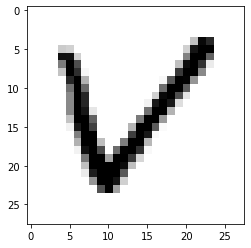

In [133]:
print(y_train_A_Z_20_25[0])
plt.figure()
plt.imshow(np.squeeze(x_train_A_Z_20_25[0]), cmap=plt.cm.binary)

In [134]:
x_train_A_Z_20_25.shape

(67181, 28, 28, 1)

### Preprocess the data


### normalization of the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [135]:
x_train_A_Z_20_25 = x_train_A_Z_20_25.astype('float32')
x_train_A_Z_20_25 /= 255

### 10-fold cross validation

In [ ]:
dsName = 'A-Z Handwritten 20-25'
epochs = 5
k_fold(x_train_A_Z_20_25, y_train_A_Z_20_25, dsName=dsName, epochs=epochs, num_of_classes=6)

outer fold = 1
Epoch 1/5
189/189 [==============================] - 2s 6ms/step - loss: 0.2822 - accuracy: 0.9021
Epoch 2/5
189/189 [==============================] - 1s 6ms/step - loss: 0.0720 - accuracy: 0.9790
Epoch 3/5
189/189 [==============================] - 1s 6ms/step - loss: 0.0454 - accuracy: 0.9878
Epoch 4/5
189/189 [==============================] - 1s 6ms/step - loss: 0.0308 - accuracy: 0.9901
Epoch 5/5
189/189 [==============================] - 1s 6ms/step - loss: 0.0284 - accuracy: 0.9902
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
376/376 [==============================] - 3s 5ms/step - loss: 0.1645 - accuracy: 0.9440
Epoch 2/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0439 - accuracy: 0.9871
Epoch 3/5
376/376 [==============================] - 2s 6ms/step - loss: 0.0280 - accuracy: 0.9914
Epoch 4/5
376/376 [==============================] - 2s 6ms/step - loss: 0.0223 - accuracy: 0.9928
Epoch 5/5
376/376 [==============================] - 2s 6ms/step - loss: 0.0199 - accuracy: 0.9931
Epoch 1/5
627/627 [==============================] - 4s 5ms/step - loss: 0.1352 - accuracy: 0.9540
Epoch 2/5
627/627 [==============================] - 3s 5ms/step - loss: 0.0397 - accuracy: 0.9867
Epoch 3/5
627/627 [==============================] - 3s 5ms/step - loss: 0.0273 - accuracy: 0.9912
Epoch 4/5
627/627 [==============================] - 3s 5ms/step - loss: 0.0221 - accuracy: 0.9921
Epoch 5/5
627/627 [==============================] - 3s 5ms/step - loss: 0.0209 - accuracy: 0.9931

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 2
Epoch 1/5
189/189 [==============================] - 1s 5ms/step - loss: 0.3126 - accuracy: 0.8978
Epoch 2/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0977 - accuracy: 0.9712
Epoch 3/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0632 - accuracy: 0.9808
Epoch 4/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0402 - accuracy: 0.9896
Epoch 5/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0340 - accuracy: 0.9891
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
376/376 [==============================] - 2s 5ms/step - loss: 0.1837 - accuracy: 0.9350
Epoch 2/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0472 - accuracy: 0.9856
Epoch 3/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0334 - accuracy: 0.9893
Epoch 4/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0269 - accuracy: 0.9908
Epoch 5/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0223 - accuracy: 0.9916
Epoch 1/5
626/626 [==============================] - 4s 5ms/step - loss: 0.1262 - accuracy: 0.9570
Epoch 2/5
626/626 [==============================] - 3s 5ms/step - loss: 0.0346 - accuracy: 0.9885
Epoch 3/5
626/626 [==============================] - 3s 5ms/step - loss: 0.0263 - accuracy: 0.9914
Epoch 4/5
626/626 [==============================] - 3s 5ms/step - loss: 0.0218 - accuracy: 0.9929
Epoch 5/5
626/626 [==============================] - 3s 5ms/step - loss: 0.0196 - accuracy: 0.9935

num_of_st

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outer fold = 3
Epoch 1/5
189/189 [==============================] - 1s 5ms/step - loss: 0.3074 - accuracy: 0.8935
Epoch 2/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0864 - accuracy: 0.9754
Epoch 3/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0553 - accuracy: 0.9831
Epoch 4/5
189/189 [==============================] - 1s 5ms/step - loss: 0.0333 - accuracy: 0.9896
Epoch 5/5
189/189 [==============================] - 1s 6ms/step - loss: 0.0238 - accuracy: 0.9922
unl_factor: 0.2
threshold: 0.6
num_of_students: 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/5
376/376 [==============================] - 2s 5ms/step - loss: 0.1963 - accuracy: 0.9321
Epoch 2/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0594 - accuracy: 0.9802
Epoch 3/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0489 - accuracy: 0.9831
Epoch 4/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0371 - accuracy: 0.9879
Epoch 5/5
376/376 [==============================] - 2s 5ms/step - loss: 0.0328 - accuracy: 0.9883
Epoch 1/5
625/625 [==============================] - 4s 5ms/step - loss: 0.1319 - accuracy: 0.9558
Epoch 2/5
625/625 [==============================] - 3s 5ms/step - loss: 0.0449 - accuracy: 0.9858
Epoch 3/5
625/625 [==============================] - 3s 5ms/step - loss: 0.0346 - accuracy: 0.9874
Epoch 4/5
625/625 [==============================] - 3s 5ms/step - loss: 0.0284 - accuracy: 0.9899
Epoch 5/5
625/625 [==============================] - 3s 5ms/step - loss: 0.0239 - accuracy: 0.9911

num_of_st

KeyboardInterrupt: ignored

# Friedman Test

read the csv file that include all the metrics for all the datasets

In [3]:
metrics_data = pd.read_csv('/content/drive/MyDrive/University/סמסטר ו/למידה חישובית יישומית/פרוייקט/metrics_table.csv')
metrics_data

Unnamed: 0           Dataset Name  ... Training Time  Inference Time
0             0          Fashion MNIST  ...     10.721917        0.379209
1             1          Fashion MNIST  ...    101.591624        1.351142
2             2          Fashion MNIST  ...    183.739418        2.927908
3             3          Fashion MNIST  ...     10.727593        0.379830
4             4          Fashion MNIST  ...    147.607676        0.913565
..          ...                    ...  ...           ...             ...
595         595  A-Z Handwritten 20-25  ...     61.073240        0.954759
596         596  A-Z Handwritten 20-25  ...    138.148064        3.675925
597         597  A-Z Handwritten 20-25  ...      6.222993        0.302449
598         598  A-Z Handwritten 20-25  ...     74.951210        0.899211
599         599  A-Z Handwritten 20-25  ...    266.810571        3.627264

[600 rows x 13 columns]

create a dictionary of the datasets used:

In [20]:
ds_names = ['Fashion MNIST', 'MNIST 0-4', 'MNIST 5-9', 'CIFAR10 0-4', 'CIFAR10 5_9', 'CIFAR100 0-9', 'CIFAR100 10-19', 'CIFAR100 20-29',
            'CIFAR100 30-39', 'CIFAR100 40-49', 'CIFAR100 50-59', 'CIFAR100 60-69', 'CIFAR100 70-79', 'CIFAR100 80-89', 'CIFAR100 90-99',
            'A-Z Handwritten 0-4', 'A-Z Handwritten 5-9', 'A-Z Handwritten 10-14', 'A-Z Handwritten 15-19', 'A-Z Handwritten 20-25']

process the data to get the average resutls for each dataset in order to use it in the friedman test:

In [14]:
# calculate the average for each algoritem for each dataset for all the 10 iteration from 10-fold cross validation
# return array with the 20 average accuracy (one for each dataset) for the algorithm that was sent to the function
def alg_metrics(alg_name):
  np_arr = np.zeros(len(ds_names))
  for i,ds in enumerate(ds_names):
    tmp_ds = metrics_data.loc[(metrics_data['Algorithm Name'] == alg_name) & (metrics_data['Dataset Name'] == ds)]
    np_arr[i] = tmp_ds['Accuracy'].sum()/10
  return np_arr

get the results for each algorithm seperatelly 

In [21]:
baseline_arr = alg_metrics('Baseline')
noisy_arr = alg_metrics('Noisy Student')
improved_arr = alg_metrics('Improved Noisy Student')

print(baseline_arr)
print(noisy_arr)
print(improved_arr)

[0.87406667 0.98447539 0.97785992 0.6202     0.7126     0.1958
 0.1994     0.2372     0.2548     0.2498     0.3124     0.3184
 0.2844     0.2612     0.3152     0.98624111 0.98783489 0.99039112
 0.99372871 0.98480221]
[0.883      0.98852802 0.98146496 0.63748    0.73848    0.2602
 0.252      0.288      0.292      0.3296     0.3318     0.3732
 0.3324     0.282      0.375      0.99010663 0.99195991 0.99234675
 0.99381228 0.98828538]
[0.88296667 0.98807042 0.98316564 0.63804    0.73412    0.2172
 0.2132     0.2554     0.2468     0.2836     0.3014     0.334
 0.288      0.2344     0.3238     0.99074348 0.99217032 0.99407672
 0.99419322 0.98917849]


## Friedman test

In [23]:
from scipy.stats import friedmanchisquare 
Q,p = friedmanchisquare(baseline_arr, noisy_arr, improved_arr)

In [24]:
print('Q is: {}, p value is: {}'.format(Q,p))

Q is: 23.69999999999999, p value is: 7.13855630669088e-06


## Post hoc test

since the friedman test shows statistical significance i.e p < 0.05 we conduct a post hoc test:

In [9]:
! pip install scikit-posthocs

     |████████████████████████████████| 51kB 4.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-cp37-none-any.whl size=37903 sha256=dbbc29f8ef40e611a494a5e7cd56aa475336bff2981f6147fff622d6f5ad73d4
  Stored in directory: /root/.cache/pip/wheels/00/0f/56/897c22820a48a74f50f1a85faaa4b133bb8865e8b094b596f5
Successfully built scikit-posthocs


In [10]:
import scikit_posthocs as sp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
# create a matrix of all the algoritms arrays
data = np.stack((baseline_arr, noisy_arr, improved_arr), axis=1)
data.shape

(20, 3)

In [19]:
sp.posthoc_nemenyi_friedman(data)

0         1         2
0  1.00000  0.001000  0.005830
1  0.00100  1.000000  0.236522
2  0.00583  0.236522  1.000000